In [161]:
# imports

import requests
import pandas as pd
import json
import html
import os.path
import numpy as np
from scipy import stats

In [162]:

p5 = ["SEC","Pac-12","FBS Independents","Big 12", "ACC", "Big Ten"]
g5 = ["Mountain West", "Mid-American","Sun Belt","Conference USA","American Athletic"]
fbs = p5 + g5
fbs

['SEC',
 'Pac-12',
 'FBS Independents',
 'Big 12',
 'ACC',
 'Big Ten',
 'Mountain West',
 'Mid-American',
 'Sun Belt',
 'Conference USA',
 'American Athletic']

In [163]:
def retrieveCfbData(endpoint, team, year, week, season_type):
    file_path = f"data/{endpoint if (endpoint != 'plays') else 'pbp'}/{endpoint[:-1] if (endpoint != 'plays') else 'pbp'}-data-{team.lower().replace(' ','-')}-{year}-wk{week}.json"
    if (os.path.exists(file_path)):
        return file_path
    res = requests.get(f"https://api.collegefootballdata.com/{endpoint}?seasonType={season_type}&year={year}&team={html.escape(team)}&week={week}")
    content = res.json()
#     with open(file_path, 'w') as f:
#         json.dump(content, f)
    return json.dumps(content)

def retrieveRemoteCfbGame(game_id, year):
    file_path = f"data/games/game-data-{game_id}.json"
    if (os.path.exists(file_path)):
        return file_path
    res = requests.get(f"https://api.collegefootballdata.com/games?year={year}&seasonType=regular&id={game_id}")
    content = res.json()
#     with open(file_path, 'w') as f:
#         json.dump(content, f)
    return json.dumps(content)
    

In [164]:
# init data retrieval
teams = pd.read_csv("data/teams/2019.csv", encoding = 'latin-1')
ep_data = pd.read_csv("results/ep.csv", encoding = 'latin-1')

base_drives = pd.DataFrame()
games = pd.DataFrame()
pbp_data = pd.DataFrame()

def retrieveCfbDataFile(endpoint, year):
    return pd.read_csv(f"data/{endpoint}/{year}.csv", encoding='latin-1')

for i in range(2012, 2020):
    drive = retrieveCfbDataFile('drives',i)
    drive['year'] = i
    base_drives = base_drives.append(drive, sort=False)
    
    gm = retrieveCfbDataFile('games',i)
    gm['year'] = i
    games = games.append(gm, sort=False)
    
    plys = retrieveCfbDataFile('pbp',i)
    plys['year'] = i
    pbp_data = pbp_data.append(plys, sort=False)

In [165]:
print(f"Total Games: {len(games)}")
print(f"Total Drives: {len(base_drives)}")
print(f"Total Plays: {len(pbp_data)}")

# print(f"2016 Drives: {len(base_drives[base_drives.game_id == 400868979])}")
# base_drives[base_drives.offense == 'Ole Miss']

Total Games: 6644
Total Drives: 172014
Total Plays: 1210147


In [166]:
# Data cleaning

games.reset_index(inplace = True) 
pbp_data.reset_index(inplace = True) 
base_drives.reset_index(inplace = True) 

base_drives = base_drives[
    (~base_drives.drive_result.isin(['Uncategorized']))
]
base_drives.drop(['offense_conference','start_time.minutes','start_time.seconds','end_time.minutes','end_time.seconds','defense_conference','elapsed.seconds','elapsed.minutes'], axis = 1, inplace=True) 
drives = pd.merge(base_drives, games[['id','away_team','home_team']], left_on='game_id', right_on='id', how='right')
drives.rename(columns={'id_x':'drive_id'}, inplace=True)
drives.drop(['id_y'], axis = 1, inplace=True)
drives.dropna(inplace=True)
print(f"Clean Drives: {len(drives)}")

drives.loc[
    drives.offense == drives.away_team, ['start_yardline']
] = 100 - drives.start_yardline
drives.loc[
    drives.offense == drives.away_team, ['end_yardline']
] = 100 - drives.end_yardline
pbp_data = pbp_data[
    (pbp_data.down != 0)
]

Clean Drives: 171110


In [167]:
pbp_data.distance = pbp_data.distance.astype(float)
# Ignore some types of plays cause they're special teams and weird
ignore_types = ["Defensive 2pt Conversion","Blocked Field Goal","Blocked Punt","Missed Field Goal Return","Blocked Punt Touchdown","Missed Field Goal Return Touchdown","Extra Point Missed","Extra Point Good","Timeout","End of Half","End of Game","Uncategorized","Penalty","Kickoff","Kickoff Return (Offense)","Kickoff Return Touchdown","Punt", "Field Goal Good","Field Goal Missed","Safety","placeholder","End of Period"]
pbp_data = pbp_data[~(pbp_data.play_type.isin(ignore_types)) & ~(pbp_data.play_text.str.contains("Penalty").astype(bool))]
bad_types = ["Interception","Pass Interception Return","Interception Return Touchdown",'Fumble Recovery (Opponent)','Sack','Fumble Return Touchdown']
pbp_data.loc[
    ((pbp_data.play_type.isin(bad_types))
     & (~pbp_data.play_type.str.contains('Sack'))) ,['yards_gained']] = 0

In [168]:
# %%timeit
if 'EqPPP' not in pbp_data.columns:
    pbp_data["EqPPP"] = pbp_data.apply(lambda x: ep_data.iloc[max(min(100, (x.yard_line + x.yards_gained)), 0)].ep - ep_data.iloc[max(min(x.yard_line, 100), 0)].ep, axis=1)

In [169]:
pbp_data.head()

,index,id,offense,offense_conference,defense,defense_conference,home,away,offense_score,defense_score,...,clock.seconds,yard_line,down,distance,yards_gained,play_type,play_text,ppa,year,EqPPP
0,0,322430009008,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,18,72,2,10.0,3,Pass Completion,Taylor Kelly pass complete to D.J. Foster for ...,-0.220409,2012,0.254253
1,1,322430009009,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,45,75,3,7.0,16,Pass Completion,Taylor Kelly pass complete to Chris Coyle for ...,1.072268,2012,1.855460
2,2,322430009011,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,6,0,...,26,91,1,9.0,9,Rush,Cameron Marshall rush for 9 yards for a TOUCHD...,NaN,2012,1.648449
4,4,322430009005,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,11,47,3,6.0,9,Rush,Taylor Kelly rush for 9 yards to the NoArz 44 ...,2.359414,2012,0.476408
5,5,322430009004,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,53,46,2,7.0,1,Rush,Cameron Marshall rush for 1 yard to the ArzSt 47.,-0.876000,2012,0.048068


In [170]:
def verify_division(num1, num2):
    if num2 == 0:
        return 0
    else:
        return num1 / num2
    
def calculate_success_in_scoring_opps(pbp, opps, team):
    opp_ids = opps.drive_id.unique()
    success = 0
    total = 0
    for opp_id in opp_ids:
        opp_set = pbp[(pbp.drive_id == opp_id) & (pbp.offense == team)]
        opp_s_rate = verify_division(len(opp_set[opp_set.play_successful == True]), len(opp_set))
        success += len(opp_set[opp_set.play_successful == True])
        total += len(opp_set)
    s_rate = 0 if total == 0 else (success / total)
    return s_rate

def calculate_score_value(drv):
    if (drv.drive_result == 'TD'):
        return 7
    elif (drv.drive_result == 'FG'):
        return 3
    elif (drv.drive_result == 'SAFETY'):
        return -2
    elif ((drv.drive_result == 'INT TD') | (drv.drive_result == 'FUMBLE TD')):
        return -7
    else:
        return 0

def calculate_ppd_in_scoring_opps(opps, team):
    scores = 0
    total = len(opps)
    scores = opps.apply(lambda x: calculate_score_value(x), axis = 1)
    ppd = 0 if total == 0 else (sum(scores) / total)
    return ppd
    
def is_successful(down, distance, yards_gained, play_type):
    if (play_type in bad_types):
        return False 
    if ((down == 1) & (yards_gained >= (0.5 * distance))):
        return True
    elif ((down == 2)) & (yards_gained >= (0.7 * distance)):
        return True
    elif ((down == 3) & (yards_gained >= distance)):
        return True
    elif ((down == 4) & (yards_gained >= distance)):
        return True
    else:
        return False
    
def is_successful_vector(play):
    if (play.play_type in bad_types):
        return False 
    if ((play.down == 1) & (play.yards_gained >= (0.5 * play.distance))):
        return True
    elif ((play.down == 2)) & (play.yards_gained >= (0.7 * play.distance)):
        return True
    elif ((play.down == 3) & (play.yards_gained >= play.distance)):
        return True
    elif ((play.down == 4) & (play.yards_gained >= play.distance)):
        return True
    else:
        return False

def is_explosive(yards_gained):
    if (yards_gained >= 15):
        return True
    else:
        return False
    
pbp_data['play_explosive'] = np.vectorize(is_explosive)(pbp_data.yards_gained)
pbp_data['play_successful'] = np.vectorize(is_successful)(pbp_data.down, pbp_data.distance, pbp_data.yards_gained, pbp_data.play_type)
    
def calculate_success_rate(pbp, exclude_types):
    return verify_division(len(pbp[(pbp.play_successful == True) & (~pbp.play_type.isin(exclude_types))]), len(pbp[(~pbp.play_type.isin(exclude_types))]))
    
def calculate_exp_rate(pbp, exclude_types):
    return verify_division(len(pbp[(pbp.play_explosive == True) & (~pbp.play_type.isin(exclude_types))]), len(pbp[(~pbp.play_type.isin(exclude_types))]))
    
standard_downs = pbp_data[
    (pbp_data.down == 1)
    | ((pbp_data.down == 2) & (pbp_data.distance <= 7))
    | ((pbp_data.down == 3) & (pbp_data.distance <= 4))
    | ((pbp_data.down == 4) & (pbp_data.distance <= 4)) 
]

passing_downs = pbp_data[
    ((pbp_data.down == 2) & (pbp_data.distance >= 8))
    | ((pbp_data.down == 3) & (pbp_data.distance >= 5))
    | ((pbp_data.down == 4) & (pbp_data.distance >= 5)) 
]

pass_types = ["Pass Reception","Pass Incompletion","Passing Touchdown","Interception","Pass Interception Return","Interception Return Touchdown","Sack"]
rush_types = ["Rush","Rushing Touchdown",'Fumble Recovery (Opponent)','Fumble Return Touchdown']

In [171]:
inputs = ['OffSR','OffER','FP','OppRate','OppEff','OppPPD','PPD','OppSR','YPP', 'ExpTO', 'ActualTO', 'AvgEqPPP', 'TotalEqPPP','IsoPPP','HavocRate']

# somewhat defined here: https://www.footballstudyhall.com/2014/1/27/5349762/five-factors-college-football-efficiency-explosiveness-isoppp#
def generate_iso_ppp(pbp, team):
    base_success = pbp[(pbp.play_successful == True) & (pbp.offense == team)]
    return base_success.EqPPP.mean() #verify_division(pbp.EqPPP.sum(), len(base_success))

def generate_team_play_stats(pbp, team):
    team_off_plays = pbp[(pbp.offense == team)]
    off_sr = calculate_success_rate(team_off_plays, [])
    off_er = calculate_exp_rate(team_off_plays, [])
    ypp = verify_division(sum(team_off_plays.yards_gained), len(team_off_plays))
    iso_ppp = generate_iso_ppp(team_off_plays, team)
    avg_eqppp = team_off_plays.EqPPP.mean()
    total_eqppp = team_off_plays.EqPPP.sum()
    return pd.DataFrame({
        'team': [team],
        "OffSR": [off_sr],
        "OffER" : [off_er],
        "YPP" : [ypp],
        "IsoPPP" : [iso_ppp],
        "AvgEqPPP" : [avg_eqppp],
        "TotalEqPPP" : [total_eqppp]
    })

def generate_team_drive_stats(drvs, pbp, gm, points, team):
    team_drives = drvs[drvs.offense == team]
    scoring_opps = team_drives[
        ((team_drives.start_yardline + team_drives.yards) >= 60)
    ]
    avg_fp = verify_division(sum(team_drives.start_yardline), len(team_drives))
    ppd = verify_division(points, len(team_drives))
    opp_effcy = verify_division(len(scoring_opps[scoring_opps.scoring == True]), len(scoring_opps))
    opp_rate = verify_division(len(scoring_opps), len(team_drives))
    opp_sr = calculate_success_in_scoring_opps(pbp, scoring_opps, team)
    opp_ppd = calculate_ppd_in_scoring_opps(scoring_opps, team)
    return pd.DataFrame({
        'team': [team],
        'FP': [avg_fp],
        'PPD': [ppd],
        'OppEff': [opp_effcy],
        'OppRate': [opp_rate],
        'OppSR': [opp_sr],
        'OppPPD': [opp_ppd]
    })

def calculate_havoc_rate(pbp, team):
    team_havoc = pbp[(pbp.defense == team) & ((((pbp.play_type == 'Pass Incompletion')
        & (pbp.play_text.str.contains('broken up', regex=False)))
        | (pbp.play_type == 'Fumble Recovery (Opponent)')
        | (pbp.play_type == 'Sack')
        | (pbp.play_type.str.contains('Interception', regex=False))
        | (pbp.yards_gained < 0))
        & (pbp.play_type != 'Penalty'))]
    return verify_division(len(team_havoc), len(pbp[(pbp.defense == team)]))

def generate_team_turnover_stats(pbp, team):
    adj_turnover_plays = pbp[
        (pbp.play_type.str.contains('Interception', regex=False))
        | ((pbp.play_type == 'Pass Incompletion')
        & (pbp.play_text.str.contains('broken up', regex=False)))
        | (pbp.play_type.str.contains('Fumble', regex=False))
    ]

    fum_plays = adj_turnover_plays[
        (adj_turnover_plays.play_type.str.contains('Fumble', regex=False))
    ]

    # away_team Adj Turnovers
    team_tos = adj_turnover_plays[
        (adj_turnover_plays.offense == team)
        | (adj_turnover_plays.defense == team)
    ]

    team_ints_off = team_tos[
       (team_tos.play_type.str.contains('Interception', regex=False))
        & (team_tos.offense == team)
    ]

    team_pds = team_tos[
       (team_tos.play_type == 'Pass Incompletion')
        & (team_tos.play_text.str.contains('broken up', regex=False))
        & (team_tos.offense == team)
    ]
    
    exp_to = (0.22 * (len(team_pds) + len(team_ints_off))) + (0.49 * len(fum_plays))
    actual_to = len(team_ints_off) + len(fum_plays[(fum_plays.offense == team) & (fum_plays.play_type.str.contains('Fumble Recovery (Opponent)', regex=False))])
    havoc = calculate_havoc_rate(pbp, team)

    return pd.DataFrame({
        'team' : [team],
        'ExpTO': [exp_to],
        'ActualTO' : [actual_to],
        'HavocRate': [havoc]
    })

st_types = ["Blocked Field Goal","Blocked Punt","Missed Field Goal Return","Blocked Punt Touchdown","Missed Field Goal Return Touchdown","Extra Point Missed","Extra Point Good","Kickoff","Kickoff Return (Offense)","Kickoff Return Touchdown","Punt","Field Goal Good","Field Goal Missed"]
def generate_team_special_teams_stats(pbp, team):
    st_plays = pbp[(pbp.play_type.isin(st_types)) & (pbp.offense == team)]
    fg_plays = st_plays[st_plays.play_type.str.contains('Field Goal')]
    kickoff_plays = st_plays[st_plays.play_type.str.contains('Kickoff')]
    punt_plays = st_plays[st_plays.play_type.str.contains('Punt')]
    
    fg_eff = verify_division(fg_plays[fg_plays.play_type.str.contains('Good')], len(fg_plays))
    #kick_returns = kickoff_plays[kickoff_plays.play_type.str.contains("Return")]
    # regex for kickoff air yards "kickoff for /d yds"
    return pd.DataFrame({
        'team' : [team],
        'FGEff': [fg_eff],
#         'PuntSR': [],
#         'KickoffSR': []
    })

def stringify_entry(team_entry):
    entries = team_entry.tolist()
    return entries[0]

def translate(value, inputMin, inputMax, outputMin, outputMax):
    leftSpan = inputMax - inputMin
    rightSpan = outputMax - outputMin

    # Convert the left range into a 0-1 range (float)
    valueScaled = float(value - inputMin) / float(leftSpan)

    # Convert the 0-1 range into a value in the right range.
    return outputMin + (valueScaled * rightSpan)

def create_expl_index(team_stat_pack):
    return translate(team_stat_pack.AvgEqPPPDiff, pbp_data.EqPPP.min()-pbp_data.EqPPP.max(), pbp_data.EqPPP.max()-pbp_data.EqPPP.min(), 0, 10)

def create_eff_index(team_stat_pack):
    return translate(team_stat_pack.OffSRDiff, -1, 1, 0, 10)

def create_fp_index(team_stat_pack):
    return translate(team_stat_pack.FPDiff, -50, 50, 0, 10)

def create_finish_drive_index(team_stat_pack):
    return translate(team_stat_pack.OppPPDDiff, -7,7,0,3.5) + translate(team_stat_pack.OppRateDiff, -1, 1, 0, 4) + translate(team_stat_pack.OppSRDiff, -1,1,0,2.5)
    # return translate(team_stat_pack.OppSRDiff, -1, 1, 0, ((5.83 + 3.38)/2.0)) + translate(team_stat_pack.IsoPPPDiff, -1, 1, 0, ((4.17+4.41)/2.0)) + translate(team_stat_pack.OffSRDiff, -1, 1, 0, ((4.17+2.21)/2))

def create_turnover_index(team_stat_pack):
    return translate(team_stat_pack.ExpTODiff - team_stat_pack.ActualTODiff, -5, 5, 0, 10)

def calculate_five_factors_rating(team_stat_pack):
    return 0.35 * create_eff_index(team_stat_pack) + 0.30 * create_expl_index(team_stat_pack) + 0.15 * create_finish_drive_index(team_stat_pack) + 0.10 * create_fp_index(team_stat_pack) + 0.10 * create_turnover_index(team_stat_pack)

def createDiffs(home, away, column):
    home[f"{column}Diff"] = home[column] - away[column]
    away[f"{column}Diff"] = away[column] - home[column]

def calculate_box_score(game_id, year):
    game_data = games[games.id == game_id]
    
    if (len(game_data) == 0):
        print(f"Could not find basic game data for game_id {game_id} locally, checking CFB Data API")
        game_data = pd.read_json(retrieveRemoteCfbGame(game_id, year))
        if (len(game_data) == 0):
            print(f"Could not find basic game data for game_id {game_id} on CFB Data API, bailing out")
            return None
    
    home_team = stringify_entry(game_data.home_team)
    away_team = stringify_entry(game_data.away_team)
    home_score = stringify_entry(game_data.home_points)
    away_score = stringify_entry(game_data.away_points)
    
    game_year = stringify_entry(game_data.season)
    game_week = stringify_entry(game_data.week)
    season_type = stringify_entry(game_data.season_type)
    
    game_drives = drives[drives.game_id == game_id]
    if ((len(game_drives) == 0)):
        print(f"Could not find drive data for game_id {game_id} locally, checking CFB Data API")
        if ((year == 2016) | (year == 2014)):
            print(f"Could not find drive data for game_id {game_id} bc of issues with 2016 and 2014 data source, bailing out")
            return None
        else:
            game_drives = pd.read_json(retrieveCfbData('drives', home_team, game_year, game_week, season_type))
            if (len(game_drives) == 0):
                print(f"Could not find drive data for game_id {game_id} on CFB Data API, bailing out")
                return None
            else:
                game_drives = pd.merge(game_drives, game_data[['id','away_team','home_team']], left_on='game_id', right_on='id', how='right')
                game_drives.rename(columns={'id_x':'drive_id'}, inplace=True)
                game_drives.drop(['id_y'], axis = 1, inplace=True)
                game_drives.dropna(inplace=True)

                game_drives.loc[
                    game_drives.offense == game_drives.away_team, ['start_yardline']
                ] = 100 - game_drives.start_yardline
                game_drives.loc[
                    game_drives.offense == game_drives.away_team, ['end_yardline']
                ] = 100 - game_drives.end_yardline
    
    game_pbp = pbp_data[pbp_data.drive_id.isin(game_drives.drive_id.tolist())]
    if (len(game_pbp) == 0):
        print(f"Could not find play by play data for game_id {game_id} locally, checking CFB Data API")
        game_pbp = pd.read_json(retrieveCfbData('plays', home_team, game_year, game_week, season_type))
        if (len(game_pbp) == 0):
            print(f"Could not find play by play data for game_id {game_id} on CFB Data API, bailing out")
            return None
    
    if 'play_explosive' not in game_pbp.columns:
        game_pbp['play_explosive'] = game_pbp.apply(lambda x: x.yards_gained >= 15, axis=1)
    if 'play_successful' not in game_pbp.columns:
        game_pbp['play_successful'] = game_pbp.apply(lambda x: is_successful_vector(x), axis=1)
    if 'EqPPP' not in game_pbp.columns:
        game_pbp['EqPPP'] = game_pbp.apply(lambda x: ep_data.iloc[max(min(100, (x.yard_line + x.yards_gained)), 0)].ep - ep_data.iloc[max(min(100, (x.yard_line)), 0)].ep, axis=1)
    
    home_team_play_stats = generate_team_play_stats(game_pbp, home_team)
    away_team_play_stats = generate_team_play_stats(game_pbp, away_team)
    
    home_team_drv_stats = generate_team_drive_stats(game_drives, game_pbp, game_data, home_score, home_team)
    away_team_drv_stats = generate_team_drive_stats(game_drives, game_pbp, game_data, away_score, away_team)
    
    home_team_stats = pd.merge(home_team_play_stats, home_team_drv_stats, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_play_stats, away_team_drv_stats, left_on="team", right_on="team", how='right')

    home_team_tos = generate_team_turnover_stats(game_pbp, home_team)
    away_team_tos = generate_team_turnover_stats(game_pbp, away_team)
    home_team_stats = pd.merge(home_team_stats, home_team_tos, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_stats, away_team_tos, left_on="team", right_on="team", how='right')
    
    for inpt in inputs:
        createDiffs(home_team_stats, away_team_stats, inpt)
    
    home_team_stats['5FR'] = calculate_five_factors_rating(home_team_stats)
    away_team_stats['5FR'] = calculate_five_factors_rating(away_team_stats)
    home_team_stats['5FRDiff'] = home_team_stats['5FR'] - away_team_stats['5FR']
    away_team_stats['5FRDiff'] = away_team_stats['5FR'] - home_team_stats['5FR']
    
    comb_stat_pack = away_team_stats.append(home_team_stats)
    
    box = pd.DataFrame({
        "team" : [away_team, home_team],
        "Season": [game_year, game_year],
        "GameID": [game_id, game_id],
        "Pts" : [away_score, home_score],
        "PtsDiff" : [away_score - home_score, home_score - away_score],
        "CfbDataWinProb" : [stringify_entry(game_data.away_post_win_prob),stringify_entry(game_data.home_post_win_prob)]
    })
    
    box = pd.merge(box, comb_stat_pack, left_on="team", right_on="team", how="right")
    box.rename(columns={"team": "Team"}, inplace=True)
    
    return box
calculate_box_score(401013183, 2018)

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Virginia,2018,401013183,31.0,-3.0,0.875665,0.396825,0.111111,6.507937,0.930578,...,0.118588,0.994779,-0.66,-1,0.103211,2.077885,0.124959,-0.040309,5.102837,0.205675
1,Virginia Tech,2018,401013183,34.0,3.0,0.124335,0.368421,0.078947,5.513158,0.805619,...,-0.118588,-0.994779,0.66,1,-0.103211,-2.077885,-0.124959,0.040309,4.897163,-0.205675


In [172]:
# %%timeit
import os.path
from os import path

game_ids = games.id.unique()
team_list = teams[teams.conference.isin(fbs)].school.tolist()
if ('stored_game_boxes' not in locals()) & (~path.exists("results/box-scores.csv")):
    print(f"[Local] Box Scores are not available, generating them from scratch...")
    stored_game_boxes = pd.DataFrame()
    for i, row in games.iterrows():
        gameId = row.id
        print(f"[{i+1}/{len(game_ids)}] Getting game information for ESPN game_id: {gameId}...")
        print(f"[{i+1}/{len(game_ids)}] Started processing game information for ESPN game_id: {gameId}...")
        if ((row.home_team in team_list) & (row.away_team in team_list)):
            box_score = calculate_box_score(gameId, row.season)
            if (box_score is not None):
                print(f"[{i+1}/{len(game_ids)}] Completed processing game information for ESPN game_id: {gameId}.")
                stored_game_boxes = stored_game_boxes.append(box_score)
                print(f"[{i+1}/{len(game_ids)}] Aggreggated game_id {gameId} to master data copy.")
            else:
                print(f"[{i+1}/{len(game_ids)}] Got 'None' for game_id {gameId}'s box score, skipping processing.")
        else:
            print(f"[{i+1}/{len(game_ids)}] Skipping checking game_id {gameId} bc one of the teams isn't FBS.")
    print(f"[Local] Finished generating {len(stored_game_boxes)} box scores and 5FR margins from scratch.")
else:
    proceed = True
    if ('stored_game_boxes' in locals()):
        print(f"Relying on 'stored_game_boxes' currently loaded into memory")
    elif (path.exists("results/box-scores.csv")):
        print(f"Loading box scores from file...")
        stored_game_boxes = pd.read_csv("results/box-scores.csv", encoding="latin-1")
    else:
        print(f"[Local] No box scores available, bailing out...")
        proceed = False
        
    if (proceed == True):
        print(f"[Local] Box Scores are available in local, updating five factors ratings now...")
        stored_game_boxes['5FR'] = stored_game_boxes.apply(lambda row: calculate_five_factors_rating(row), axis=1)
        print(f"[Local] Grouping box score rows by GameID...")
        groups = stored_game_boxes.groupby('GameID')
        print(f"[Local] Generated {len(groups)} box score groups by GameID.")
        current = 0
        for (name, group) in groups:
            print(f"[{current+1}/{len(groups)}] Updating 5FR Margin for game_id {name}...")
            group_ratings = group['5FR']
            top_diff = group_ratings.iloc[0] - group_ratings.iloc[1]
            bot_diff = group_ratings.iloc[1] - group_ratings.iloc[0]
            group['5FRDiff'] = [top_diff, bot_diff]
            print(f"[{current+1}/{len(groups)}] Updated 5FR Margin for game_id {name}.")
            current+=1
        print(f"[Local] Finished updating box scores with new 5FR margins.")

if ('stored_game_boxes' in locals()):
    print(f"[Local] Writing updated box scores to file...")
    stored_game_boxes.dropna(inplace=True)
    stored_game_boxes.to_csv("results/box-scores.csv", index=False, sep=",")
    print(f"[Local] Wrote updated box scores to file.")
    stored_game_boxes.head()

Relying on 'stored_game_boxes' currently loaded into memory
[Local] Box Scores are available in local, updating five factors ratings now...
[Local] Grouping box score rows by GameID...
[Local] Generated 4973 box score groups by GameID.
[1/4973] Updating 5FR Margin for game_id 322430041...
[1/4973] Updated 5FR Margin for game_id 322430041.
[2/4973] Updating 5FR Margin for game_id 322430238...
[2/4973] Updated 5FR Margin for game_id 322430238.
[3/4973] Updating 5FR Margin for game_id 322430242...
[3/4973] Updated 5FR Margin for game_id 322430242.
[4/4973] Updating 5FR Margin for game_id 322430252...
[4/4973] Updated 5FR Margin for game_id 322430252.
[5/4973] Updating 5FR Margin for game_id 322432006...
[5/4973] Updated 5FR Margin for game_id 322432006.
[6/4973] Updating 5FR Margin for game_id 322432050...
[6/4973] Updated 5FR Margin for game_id 322432050.
[7/4973] Updating 5FR Margin for game_id 322432439...
[7/4973] Updated 5FR Margin for game_id 322432439.
[8/4973] Updating 5FR Margin 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



[214/4973] Updating 5FR Margin for game_id 322732006...
[214/4973] Updated 5FR Margin for game_id 322732006.
[215/4973] Updating 5FR Margin for game_id 322732032...
[215/4973] Updated 5FR Margin for game_id 322732032.
[216/4973] Updating 5FR Margin for game_id 322732116...
[216/4973] Updated 5FR Margin for game_id 322732116.
[217/4973] Updating 5FR Margin for game_id 322732132...
[217/4973] Updated 5FR Margin for game_id 322732132.
[218/4973] Updating 5FR Margin for game_id 322732226...
[218/4973] Updated 5FR Margin for game_id 322732226.
[219/4973] Updating 5FR Margin for game_id 322732294...
[219/4973] Updated 5FR Margin for game_id 322732294.
[220/4973] Updating 5FR Margin for game_id 322732309...
[220/4973] Updated 5FR Margin for game_id 322732309.
[221/4973] Updating 5FR Margin for game_id 322732390...
[221/4973] Updated 5FR Margin for game_id 322732390.
[222/4973] Updating 5FR Margin for game_id 322732426...
[222/4973] Updated 5FR Margin for game_id 322732426.
[223/4973] Updatin

[435/4973] Updating 5FR Margin for game_id 323012393...
[435/4973] Updated 5FR Margin for game_id 323012393.
[436/4973] Updating 5FR Margin for game_id 323012433...
[436/4973] Updated 5FR Margin for game_id 323012433.
[437/4973] Updating 5FR Margin for game_id 323012483...
[437/4973] Updated 5FR Margin for game_id 323012483.
[438/4973] Updating 5FR Margin for game_id 323012567...
[438/4973] Updated 5FR Margin for game_id 323012567.
[439/4973] Updating 5FR Margin for game_id 323012579...
[439/4973] Updated 5FR Margin for game_id 323012579.
[440/4973] Updating 5FR Margin for game_id 323012636...
[440/4973] Updated 5FR Margin for game_id 323012636.
[441/4973] Updating 5FR Margin for game_id 323012655...
[441/4973] Updated 5FR Margin for game_id 323012655.
[442/4973] Updating 5FR Margin for game_id 323012711...
[442/4973] Updated 5FR Margin for game_id 323012711.
[443/4973] Updating 5FR Margin for game_id 323012751...
[443/4973] Updated 5FR Margin for game_id 323012751.
[444/4973] Updating

[656/4973] Updating 5FR Margin for game_id 323292567...
[656/4973] Updated 5FR Margin for game_id 323292567.
[657/4973] Updating 5FR Margin for game_id 323292633...
[657/4973] Updated 5FR Margin for game_id 323292633.
[658/4973] Updating 5FR Margin for game_id 323292636...
[658/4973] Updated 5FR Margin for game_id 323292636.
[659/4973] Updating 5FR Margin for game_id 323292638...
[659/4973] Updated 5FR Margin for game_id 323292638.
[660/4973] Updating 5FR Margin for game_id 323292641...
[660/4973] Updated 5FR Margin for game_id 323292641.
[661/4973] Updating 5FR Margin for game_id 323292751...
[661/4973] Updated 5FR Margin for game_id 323292751.
[662/4973] Updating 5FR Margin for game_id 323340164...
[662/4973] Updated 5FR Margin for game_id 323340164.
[663/4973] Updating 5FR Margin for game_id 323350024...
[663/4973] Updated 5FR Margin for game_id 323350024.
[664/4973] Updating 5FR Margin for game_id 323352309...
[664/4973] Updated 5FR Margin for game_id 323352309.
[665/4973] Updating

[877/4973] Updating 5FR Margin for game_id 332710204...
[877/4973] Updated 5FR Margin for game_id 332710204.
[878/4973] Updating 5FR Margin for game_id 332710221...
[878/4973] Updated 5FR Margin for game_id 332710221.
[879/4973] Updating 5FR Margin for game_id 332710228...
[879/4973] Updated 5FR Margin for game_id 332710228.
[880/4973] Updating 5FR Margin for game_id 332710238...
[880/4973] Updated 5FR Margin for game_id 332710238.
[881/4973] Updating 5FR Margin for game_id 332710242...
[881/4973] Updated 5FR Margin for game_id 332710242.
[882/4973] Updating 5FR Margin for game_id 332710264...
[882/4973] Updated 5FR Margin for game_id 332710264.
[883/4973] Updating 5FR Margin for game_id 332710265...
[883/4973] Updated 5FR Margin for game_id 332710265.
[884/4973] Updating 5FR Margin for game_id 332710277...
[884/4973] Updated 5FR Margin for game_id 332710277.
[885/4973] Updating 5FR Margin for game_id 332710326...
[885/4973] Updated 5FR Margin for game_id 332710326.
[886/4973] Updating

[1096/4973] Updated 5FR Margin for game_id 332992440.
[1097/4973] Updating 5FR Margin for game_id 332992459...
[1097/4973] Updated 5FR Margin for game_id 332992459.
[1098/4973] Updating 5FR Margin for game_id 332992483...
[1098/4973] Updated 5FR Margin for game_id 332992483.
[1099/4973] Updating 5FR Margin for game_id 332992567...
[1099/4973] Updated 5FR Margin for game_id 332992567.
[1100/4973] Updating 5FR Margin for game_id 332992572...
[1100/4973] Updated 5FR Margin for game_id 332992572.
[1101/4973] Updating 5FR Margin for game_id 332992628...
[1101/4973] Updated 5FR Margin for game_id 332992628.
[1102/4973] Updating 5FR Margin for game_id 332992636...
[1102/4973] Updated 5FR Margin for game_id 332992636.
[1103/4973] Updating 5FR Margin for game_id 332992655...
[1103/4973] Updated 5FR Margin for game_id 332992655.
[1104/4973] Updating 5FR Margin for game_id 333030235...
[1104/4973] Updated 5FR Margin for game_id 333030235.
[1105/4973] Updating 5FR Margin for game_id 333040248...
[

[1324/4973] Updated 5FR Margin for game_id 333332226.
[1325/4973] Updating 5FR Margin for game_id 333332483...
[1325/4973] Updated 5FR Margin for game_id 333332483.
[1326/4973] Updating 5FR Margin for game_id 333332653...
[1326/4973] Updated 5FR Margin for game_id 333332653.
[1327/4973] Updating 5FR Margin for game_id 333340002...
[1327/4973] Updated 5FR Margin for game_id 333340002.
[1328/4973] Updating 5FR Margin for game_id 333340005...
[1328/4973] Updated 5FR Margin for game_id 333340005.
[1329/4973] Updating 5FR Margin for game_id 333340009...
[1329/4973] Updated 5FR Margin for game_id 333340009.
[1330/4973] Updating 5FR Margin for game_id 333340024...
[1330/4973] Updated 5FR Margin for game_id 333340024.
[1331/4973] Updating 5FR Margin for game_id 333340030...
[1331/4973] Updated 5FR Margin for game_id 333340030.
[1332/4973] Updating 5FR Margin for game_id 333340036...
[1332/4973] Updated 5FR Margin for game_id 333340036.
[1333/4973] Updating 5FR Margin for game_id 333340041...
[

[1549/4973] Updating 5FR Margin for game_id 400756977...
[1549/4973] Updated 5FR Margin for game_id 400756977.
[1550/4973] Updating 5FR Margin for game_id 400756978...
[1550/4973] Updated 5FR Margin for game_id 400756978.
[1551/4973] Updating 5FR Margin for game_id 400756979...
[1551/4973] Updated 5FR Margin for game_id 400756979.
[1552/4973] Updating 5FR Margin for game_id 400756980...
[1552/4973] Updated 5FR Margin for game_id 400756980.
[1553/4973] Updating 5FR Margin for game_id 400756981...
[1553/4973] Updated 5FR Margin for game_id 400756981.
[1554/4973] Updating 5FR Margin for game_id 400756982...
[1554/4973] Updated 5FR Margin for game_id 400756982.
[1555/4973] Updating 5FR Margin for game_id 400756983...
[1555/4973] Updated 5FR Margin for game_id 400756983.
[1556/4973] Updating 5FR Margin for game_id 400756984...
[1556/4973] Updated 5FR Margin for game_id 400756984.
[1557/4973] Updating 5FR Margin for game_id 400756985...
[1557/4973] Updated 5FR Margin for game_id 400756985.
[

[1776/4973] Updating 5FR Margin for game_id 400763561...
[1776/4973] Updated 5FR Margin for game_id 400763561.
[1777/4973] Updating 5FR Margin for game_id 400763562...
[1777/4973] Updated 5FR Margin for game_id 400763562.
[1778/4973] Updating 5FR Margin for game_id 400763563...
[1778/4973] Updated 5FR Margin for game_id 400763563.
[1779/4973] Updating 5FR Margin for game_id 400763564...
[1779/4973] Updated 5FR Margin for game_id 400763564.
[1780/4973] Updating 5FR Margin for game_id 400763565...
[1780/4973] Updated 5FR Margin for game_id 400763565.
[1781/4973] Updating 5FR Margin for game_id 400763566...
[1781/4973] Updated 5FR Margin for game_id 400763566.
[1782/4973] Updating 5FR Margin for game_id 400763567...
[1782/4973] Updated 5FR Margin for game_id 400763567.
[1783/4973] Updating 5FR Margin for game_id 400763568...
[1783/4973] Updated 5FR Margin for game_id 400763568.
[1784/4973] Updating 5FR Margin for game_id 400763569...
[1784/4973] Updated 5FR Margin for game_id 400763569.
[

[2003/4973] Updating 5FR Margin for game_id 400787334...
[2003/4973] Updated 5FR Margin for game_id 400787334.
[2004/4973] Updating 5FR Margin for game_id 400787335...
[2004/4973] Updated 5FR Margin for game_id 400787335.
[2005/4973] Updating 5FR Margin for game_id 400787336...
[2005/4973] Updated 5FR Margin for game_id 400787336.
[2006/4973] Updating 5FR Margin for game_id 400787337...
[2006/4973] Updated 5FR Margin for game_id 400787337.
[2007/4973] Updating 5FR Margin for game_id 400787338...
[2007/4973] Updated 5FR Margin for game_id 400787338.
[2008/4973] Updating 5FR Margin for game_id 400787339...
[2008/4973] Updated 5FR Margin for game_id 400787339.
[2009/4973] Updating 5FR Margin for game_id 400787340...
[2009/4973] Updated 5FR Margin for game_id 400787340.
[2010/4973] Updating 5FR Margin for game_id 400787341...
[2010/4973] Updated 5FR Margin for game_id 400787341.
[2011/4973] Updating 5FR Margin for game_id 400787342...
[2011/4973] Updated 5FR Margin for game_id 400787342.
[

[2225/4973] Updated 5FR Margin for game_id 400869068.
[2226/4973] Updating 5FR Margin for game_id 400869069...
[2226/4973] Updated 5FR Margin for game_id 400869069.
[2227/4973] Updating 5FR Margin for game_id 400869070...
[2227/4973] Updated 5FR Margin for game_id 400869070.
[2228/4973] Updating 5FR Margin for game_id 400869071...
[2228/4973] Updated 5FR Margin for game_id 400869071.
[2229/4973] Updating 5FR Margin for game_id 400869072...
[2229/4973] Updated 5FR Margin for game_id 400869072.
[2230/4973] Updating 5FR Margin for game_id 400869073...
[2230/4973] Updated 5FR Margin for game_id 400869073.
[2231/4973] Updating 5FR Margin for game_id 400869074...
[2231/4973] Updated 5FR Margin for game_id 400869074.
[2232/4973] Updating 5FR Margin for game_id 400869075...
[2232/4973] Updated 5FR Margin for game_id 400869075.
[2233/4973] Updating 5FR Margin for game_id 400869090...
[2233/4973] Updated 5FR Margin for game_id 400869090.
[2234/4973] Updating 5FR Margin for game_id 400869092...
[

[2430/4973] Updated 5FR Margin for game_id 400869326.
[2431/4973] Updating 5FR Margin for game_id 400869327...
[2431/4973] Updated 5FR Margin for game_id 400869327.
[2432/4973] Updating 5FR Margin for game_id 400869328...
[2432/4973] Updated 5FR Margin for game_id 400869328.
[2433/4973] Updating 5FR Margin for game_id 400869329...
[2433/4973] Updated 5FR Margin for game_id 400869329.
[2434/4973] Updating 5FR Margin for game_id 400869330...
[2434/4973] Updated 5FR Margin for game_id 400869330.
[2435/4973] Updating 5FR Margin for game_id 400869331...
[2435/4973] Updated 5FR Margin for game_id 400869331.
[2436/4973] Updating 5FR Margin for game_id 400869332...
[2436/4973] Updated 5FR Margin for game_id 400869332.
[2437/4973] Updating 5FR Margin for game_id 400869333...
[2437/4973] Updated 5FR Margin for game_id 400869333.
[2438/4973] Updating 5FR Margin for game_id 400869334...
[2438/4973] Updated 5FR Margin for game_id 400869334.
[2439/4973] Updating 5FR Margin for game_id 400869335...
[

[2639/4973] Updating 5FR Margin for game_id 400869594...
[2639/4973] Updated 5FR Margin for game_id 400869594.
[2640/4973] Updating 5FR Margin for game_id 400869595...
[2640/4973] Updated 5FR Margin for game_id 400869595.
[2641/4973] Updating 5FR Margin for game_id 400869596...
[2641/4973] Updated 5FR Margin for game_id 400869596.
[2642/4973] Updating 5FR Margin for game_id 400869598...
[2642/4973] Updated 5FR Margin for game_id 400869598.
[2643/4973] Updating 5FR Margin for game_id 400869599...
[2643/4973] Updated 5FR Margin for game_id 400869599.
[2644/4973] Updating 5FR Margin for game_id 400869600...
[2644/4973] Updated 5FR Margin for game_id 400869600.
[2645/4973] Updating 5FR Margin for game_id 400869601...
[2645/4973] Updated 5FR Margin for game_id 400869601.
[2646/4973] Updating 5FR Margin for game_id 400869602...
[2646/4973] Updated 5FR Margin for game_id 400869602.
[2647/4973] Updating 5FR Margin for game_id 400869603...
[2647/4973] Updated 5FR Margin for game_id 400869603.
[

[2849/4973] Updating 5FR Margin for game_id 400933900...
[2849/4973] Updated 5FR Margin for game_id 400933900.
[2850/4973] Updating 5FR Margin for game_id 400933901...
[2850/4973] Updated 5FR Margin for game_id 400933901.
[2851/4973] Updating 5FR Margin for game_id 400933902...
[2851/4973] Updated 5FR Margin for game_id 400933902.
[2852/4973] Updating 5FR Margin for game_id 400933903...
[2852/4973] Updated 5FR Margin for game_id 400933903.
[2853/4973] Updating 5FR Margin for game_id 400933904...
[2853/4973] Updated 5FR Margin for game_id 400933904.
[2854/4973] Updating 5FR Margin for game_id 400933905...
[2854/4973] Updated 5FR Margin for game_id 400933905.
[2855/4973] Updating 5FR Margin for game_id 400933906...
[2855/4973] Updated 5FR Margin for game_id 400933906.
[2856/4973] Updating 5FR Margin for game_id 400933907...
[2856/4973] Updated 5FR Margin for game_id 400933907.
[2857/4973] Updating 5FR Margin for game_id 400933908...
[2857/4973] Updated 5FR Margin for game_id 400933908.
[

[3069/4973] Updated 5FR Margin for game_id 400935349.
[3070/4973] Updating 5FR Margin for game_id 400935351...
[3070/4973] Updated 5FR Margin for game_id 400935351.
[3071/4973] Updating 5FR Margin for game_id 400935352...
[3071/4973] Updated 5FR Margin for game_id 400935352.
[3072/4973] Updating 5FR Margin for game_id 400935353...
[3072/4973] Updated 5FR Margin for game_id 400935353.
[3073/4973] Updating 5FR Margin for game_id 400935354...
[3073/4973] Updated 5FR Margin for game_id 400935354.
[3074/4973] Updating 5FR Margin for game_id 400935355...
[3074/4973] Updated 5FR Margin for game_id 400935355.
[3075/4973] Updating 5FR Margin for game_id 400935356...
[3075/4973] Updated 5FR Margin for game_id 400935356.
[3076/4973] Updating 5FR Margin for game_id 400935359...
[3076/4973] Updated 5FR Margin for game_id 400935359.
[3077/4973] Updating 5FR Margin for game_id 400935360...
[3077/4973] Updated 5FR Margin for game_id 400935360.
[3078/4973] Updating 5FR Margin for game_id 400935361...
[

[3292/4973] Updating 5FR Margin for game_id 400941786...
[3292/4973] Updated 5FR Margin for game_id 400941786.
[3293/4973] Updating 5FR Margin for game_id 400941789...
[3293/4973] Updated 5FR Margin for game_id 400941789.
[3294/4973] Updating 5FR Margin for game_id 400941798...
[3294/4973] Updated 5FR Margin for game_id 400941798.
[3295/4973] Updating 5FR Margin for game_id 400941799...
[3295/4973] Updated 5FR Margin for game_id 400941799.
[3296/4973] Updating 5FR Margin for game_id 400941800...
[3296/4973] Updated 5FR Margin for game_id 400941800.
[3297/4973] Updating 5FR Margin for game_id 400941801...
[3297/4973] Updated 5FR Margin for game_id 400941801.
[3298/4973] Updating 5FR Margin for game_id 400941802...
[3298/4973] Updated 5FR Margin for game_id 400941802.
[3299/4973] Updating 5FR Margin for game_id 400941803...
[3299/4973] Updated 5FR Margin for game_id 400941803.
[3300/4973] Updating 5FR Margin for game_id 400941804...
[3300/4973] Updated 5FR Margin for game_id 400941804.
[

[3514/4973] Updating 5FR Margin for game_id 401012253...
[3514/4973] Updated 5FR Margin for game_id 401012253.
[3515/4973] Updating 5FR Margin for game_id 401012256...
[3515/4973] Updated 5FR Margin for game_id 401012256.
[3516/4973] Updating 5FR Margin for game_id 401012257...
[3516/4973] Updated 5FR Margin for game_id 401012257.
[3517/4973] Updating 5FR Margin for game_id 401012259...
[3517/4973] Updated 5FR Margin for game_id 401012259.
[3518/4973] Updating 5FR Margin for game_id 401012260...
[3518/4973] Updated 5FR Margin for game_id 401012260.
[3519/4973] Updating 5FR Margin for game_id 401012261...
[3519/4973] Updated 5FR Margin for game_id 401012261.
[3520/4973] Updating 5FR Margin for game_id 401012263...
[3520/4973] Updated 5FR Margin for game_id 401012263.
[3521/4973] Updating 5FR Margin for game_id 401012266...
[3521/4973] Updated 5FR Margin for game_id 401012266.
[3522/4973] Updating 5FR Margin for game_id 401012267...
[3522/4973] Updated 5FR Margin for game_id 401012267.
[

[3734/4973] Updated 5FR Margin for game_id 401012880.
[3735/4973] Updating 5FR Margin for game_id 401012881...
[3735/4973] Updated 5FR Margin for game_id 401012881.
[3736/4973] Updating 5FR Margin for game_id 401012882...
[3736/4973] Updated 5FR Margin for game_id 401012882.
[3737/4973] Updating 5FR Margin for game_id 401012883...
[3737/4973] Updated 5FR Margin for game_id 401012883.
[3738/4973] Updating 5FR Margin for game_id 401012884...
[3738/4973] Updated 5FR Margin for game_id 401012884.
[3739/4973] Updating 5FR Margin for game_id 401012885...
[3739/4973] Updated 5FR Margin for game_id 401012885.
[3740/4973] Updating 5FR Margin for game_id 401012886...
[3740/4973] Updated 5FR Margin for game_id 401012886.
[3741/4973] Updating 5FR Margin for game_id 401012887...
[3741/4973] Updated 5FR Margin for game_id 401012887.
[3742/4973] Updating 5FR Margin for game_id 401012888...
[3742/4973] Updated 5FR Margin for game_id 401012888.
[3743/4973] Updating 5FR Margin for game_id 401012889...
[

[3956/4973] Updated 5FR Margin for game_id 401014977.
[3957/4973] Updating 5FR Margin for game_id 401014981...
[3957/4973] Updated 5FR Margin for game_id 401014981.
[3958/4973] Updating 5FR Margin for game_id 401014982...
[3958/4973] Updated 5FR Margin for game_id 401014982.
[3959/4973] Updating 5FR Margin for game_id 401014983...
[3959/4973] Updated 5FR Margin for game_id 401014983.
[3960/4973] Updating 5FR Margin for game_id 401014988...
[3960/4973] Updated 5FR Margin for game_id 401014988.
[3961/4973] Updating 5FR Margin for game_id 401014989...
[3961/4973] Updated 5FR Margin for game_id 401014989.
[3962/4973] Updating 5FR Margin for game_id 401014990...
[3962/4973] Updated 5FR Margin for game_id 401014990.
[3963/4973] Updating 5FR Margin for game_id 401014991...
[3963/4973] Updated 5FR Margin for game_id 401014991.
[3964/4973] Updating 5FR Margin for game_id 401014993...
[3964/4973] Updated 5FR Margin for game_id 401014993.
[3965/4973] Updating 5FR Margin for game_id 401014996...
[

[4129/4973] Updated 5FR Margin for game_id 401020786.
[4130/4973] Updating 5FR Margin for game_id 401020787...
[4130/4973] Updated 5FR Margin for game_id 401020787.
[4131/4973] Updating 5FR Margin for game_id 401020788...
[4131/4973] Updated 5FR Margin for game_id 401020788.
[4132/4973] Updating 5FR Margin for game_id 401020789...
[4132/4973] Updated 5FR Margin for game_id 401020789.
[4133/4973] Updating 5FR Margin for game_id 401020790...
[4133/4973] Updated 5FR Margin for game_id 401020790.
[4134/4973] Updating 5FR Margin for game_id 401020810...
[4134/4973] Updated 5FR Margin for game_id 401020810.
[4135/4973] Updating 5FR Margin for game_id 401020811...
[4135/4973] Updated 5FR Margin for game_id 401020811.
[4136/4973] Updating 5FR Margin for game_id 401020812...
[4136/4973] Updated 5FR Margin for game_id 401020812.
[4137/4973] Updating 5FR Margin for game_id 401021656...
[4137/4973] Updated 5FR Margin for game_id 401021656.
[4138/4973] Updating 5FR Margin for game_id 401021660...
[

[4327/4973] Updating 5FR Margin for game_id 401110857...
[4327/4973] Updated 5FR Margin for game_id 401110857.
[4328/4973] Updating 5FR Margin for game_id 401110859...
[4328/4973] Updated 5FR Margin for game_id 401110859.
[4329/4973] Updating 5FR Margin for game_id 401110861...
[4329/4973] Updated 5FR Margin for game_id 401110861.
[4330/4973] Updating 5FR Margin for game_id 401110863...
[4330/4973] Updated 5FR Margin for game_id 401110863.
[4331/4973] Updating 5FR Margin for game_id 401110864...
[4331/4973] Updated 5FR Margin for game_id 401110864.
[4332/4973] Updating 5FR Margin for game_id 401110865...
[4332/4973] Updated 5FR Margin for game_id 401110865.
[4333/4973] Updating 5FR Margin for game_id 401110866...
[4333/4973] Updated 5FR Margin for game_id 401110866.
[4334/4973] Updating 5FR Margin for game_id 401110867...
[4334/4973] Updated 5FR Margin for game_id 401110867.
[4335/4973] Updating 5FR Margin for game_id 401110868...
[4335/4973] Updated 5FR Margin for game_id 401110868.
[

[4545/4973] Updated 5FR Margin for game_id 401112486.
[4546/4973] Updating 5FR Margin for game_id 401112487...
[4546/4973] Updated 5FR Margin for game_id 401112487.
[4547/4973] Updating 5FR Margin for game_id 401112488...
[4547/4973] Updated 5FR Margin for game_id 401112488.
[4548/4973] Updating 5FR Margin for game_id 401112489...
[4548/4973] Updated 5FR Margin for game_id 401112489.
[4549/4973] Updating 5FR Margin for game_id 401112490...
[4549/4973] Updated 5FR Margin for game_id 401112490.
[4550/4973] Updating 5FR Margin for game_id 401112491...
[4550/4973] Updated 5FR Margin for game_id 401112491.
[4551/4973] Updating 5FR Margin for game_id 401112492...
[4551/4973] Updated 5FR Margin for game_id 401112492.
[4552/4973] Updating 5FR Margin for game_id 401112493...
[4552/4973] Updated 5FR Margin for game_id 401112493.
[4553/4973] Updating 5FR Margin for game_id 401112494...
[4553/4973] Updated 5FR Margin for game_id 401112494.
[4554/4973] Updating 5FR Margin for game_id 401112495...
[

[4766/4973] Updated 5FR Margin for game_id 401117506.
[4767/4973] Updating 5FR Margin for game_id 401117507...
[4767/4973] Updated 5FR Margin for game_id 401117507.
[4768/4973] Updating 5FR Margin for game_id 401117508...
[4768/4973] Updated 5FR Margin for game_id 401117508.
[4769/4973] Updating 5FR Margin for game_id 401117509...
[4769/4973] Updated 5FR Margin for game_id 401117509.
[4770/4973] Updating 5FR Margin for game_id 401117512...
[4770/4973] Updated 5FR Margin for game_id 401117512.
[4771/4973] Updating 5FR Margin for game_id 401117513...
[4771/4973] Updated 5FR Margin for game_id 401117513.
[4772/4973] Updating 5FR Margin for game_id 401117514...
[4772/4973] Updated 5FR Margin for game_id 401117514.
[4773/4973] Updating 5FR Margin for game_id 401117515...
[4773/4973] Updated 5FR Margin for game_id 401117515.
[4774/4973] Updating 5FR Margin for game_id 401117516...
[4774/4973] Updated 5FR Margin for game_id 401117516.
[4775/4973] Updating 5FR Margin for game_id 401117517...
[

[Local] Wrote updated box scores to file.


In [173]:
stored_game_boxes.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,UCF,2012,322432006,56.0,42.0,0.796214,0.492537,0.074627,6.029851,0.683285,...,-0.22,0,0.122680,4.387538,0.04152,0.006633,5.436102,0.872203,0.943246,1.899151
1,Akron,2012,322432006,14.0,-42.0,0.203786,0.382716,0.061728,4.370370,0.641765,...,0.22,0,-0.122680,-4.387538,-0.04152,-0.006633,4.563898,-0.872203,0.943246,1.899151
2,South Carolina,2012,322430238,17.0,4.0,0.518995,0.435484,0.080645,5.129032,0.749257,...,0.22,0,0.017305,2.138834,-0.42232,0.042920,5.208914,0.417828,0.451861,0.180871
3,Vanderbilt,2012,322430238,13.0,-4.0,0.481005,0.271186,0.152542,5.813559,1.171577,...,-0.22,0,-0.017305,-2.138834,0.42232,-0.042920,4.791086,-0.417828,0.451861,0.180871
4,Eastern Michigan,2012,322432050,26.0,-11.0,0.020080,0.447761,0.134328,6.119403,1.072704,...,0.00,0,0.087917,-6.578618,0.26167,0.059391,4.731171,-0.537657,0.581451,0.497397


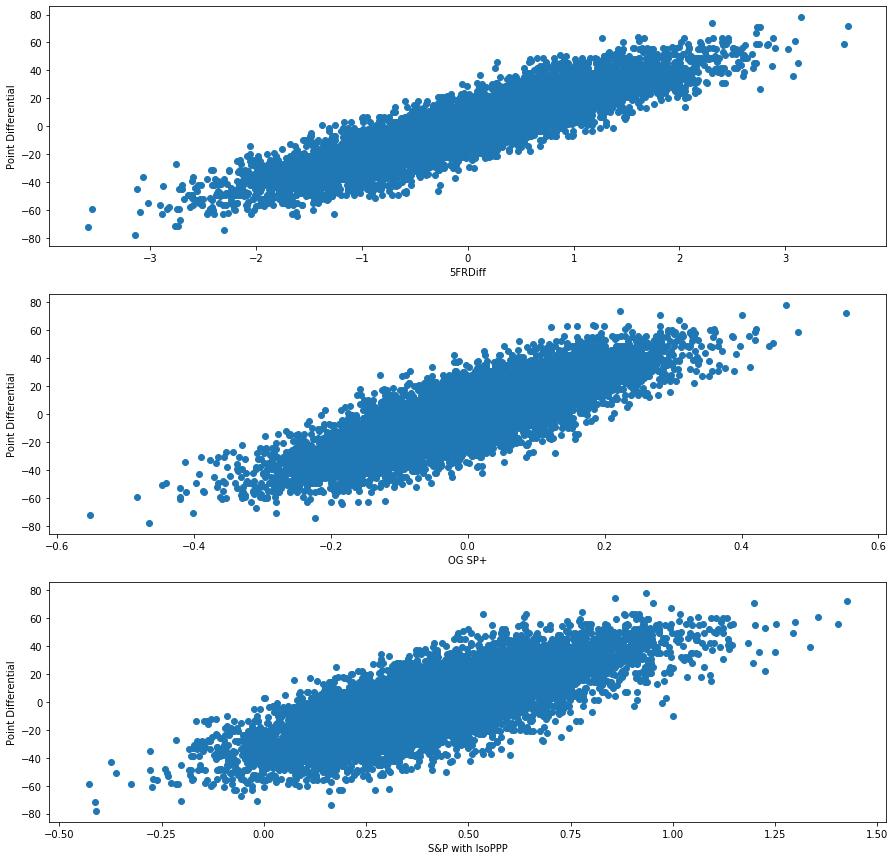

In [174]:
%matplotlib inline
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
f, axes = plt.subplots(3, figsize=(15, 15))#plt.subplots(len(inputs), figsize=(20, len(inputs) * 8))

# for i in range(len(inputs)):
#     inpt = inputs[i]
axes[0].scatter(stored_game_boxes[f"5FRDiff"], stored_game_boxes.PtsDiff);
axes[0].set_xlabel("5FRDiff")
axes[0].set_ylabel("Point Differential");

axes[1].scatter(0.86*stored_game_boxes[f"OffSRDiff"] + 0.14*stored_game_boxes[f"IsoPPPDiff"], stored_game_boxes.PtsDiff);
axes[1].set_xlabel("OG SP+")
axes[1].set_ylabel("Point Differential");

axes[2].scatter(stored_game_boxes[f"OffSRDiff"] + stored_game_boxes[f"AvgEqPPP"], stored_game_boxes.PtsDiff);
axes[2].set_xlabel("S&P with IsoPPP")
axes[2].set_ylabel("Point Differential");

In [175]:
sp_isoppp = 0.86*stored_game_boxes[f"OffSRDiff"] + 0.14*stored_game_boxes[f"IsoPPPDiff"]
sp_eqppp = stored_game_boxes[f"OffSRDiff"] + stored_game_boxes[f"AvgEqPPP"]
correl = pd.DataFrame(data={"OGS&PDiff":sp_eqppp,"S&PIsoPPPDiff":sp_isoppp,"PtsDiff":stored_game_boxes.PtsDiff})
correl.corr()

,OGS&PDiff,S&PIsoPPPDiff,PtsDiff
OGS&PDiff,1.000000,0.912285,0.757657
S&PIsoPPPDiff,0.912285,1.000000,0.814933
PtsDiff,0.757657,0.814933,1.000000


In [176]:
# Eliminate outliers
from scipy import stats
import numpy as np
stored_game_boxes['5fr_z_score'] = np.abs(stats.zscore(stored_game_boxes['5FRDiff']))
stored_game_boxes['pts_z_score'] = np.abs(stats.zscore(stored_game_boxes.PtsDiff))
stored_game_boxes.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,UCF,2012,322432006,56.0,42.0,0.796214,0.492537,0.074627,6.029851,0.683285,...,-0.22,0,0.122680,4.387538,0.04152,0.006633,5.436102,0.872203,0.943246,1.899151
1,Akron,2012,322432006,14.0,-42.0,0.203786,0.382716,0.061728,4.370370,0.641765,...,0.22,0,-0.122680,-4.387538,-0.04152,-0.006633,4.563898,-0.872203,0.943246,1.899151
2,South Carolina,2012,322430238,17.0,4.0,0.518995,0.435484,0.080645,5.129032,0.749257,...,0.22,0,0.017305,2.138834,-0.42232,0.042920,5.208914,0.417828,0.451861,0.180871
3,Vanderbilt,2012,322430238,13.0,-4.0,0.481005,0.271186,0.152542,5.813559,1.171577,...,-0.22,0,-0.017305,-2.138834,0.42232,-0.042920,4.791086,-0.417828,0.451861,0.180871
4,Eastern Michigan,2012,322432050,26.0,-11.0,0.020080,0.447761,0.134328,6.119403,1.072704,...,0.00,0,0.087917,-6.578618,0.26167,0.059391,4.731171,-0.537657,0.581451,0.497397


In [177]:
outliers = stored_game_boxes[(stored_game_boxes['5fr_z_score'] >= 3.2) | (stored_game_boxes['pts_z_score'] >= 3)]
basis = stored_game_boxes[(stored_game_boxes['5fr_z_score'] < 3.2) & (stored_game_boxes['pts_z_score'] < 3.)]
msk = (np.random.rand(len(basis)) < 0.80)
train_data = basis[msk]
test_data = basis[~msk]

In [178]:
# outliers

In [179]:
train_data.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,UCF,2012,322432006,56.0,42.0,0.796214,0.492537,0.074627,6.029851,0.683285,...,-0.22,0,0.122680,4.387538,0.041520,0.006633,5.436102,0.872203,0.943246,1.899151
1,Akron,2012,322432006,14.0,-42.0,0.203786,0.382716,0.061728,4.370370,0.641765,...,0.22,0,-0.122680,-4.387538,-0.041520,-0.006633,4.563898,-0.872203,0.943246,1.899151
5,Ball State,2012,322432050,37.0,11.0,0.979920,0.510417,0.083333,6.291667,0.811034,...,0.00,0,-0.087917,6.578618,-0.261670,-0.059391,5.268829,0.537657,0.581451,0.497397
6,UMass,2012,322430041,0.0,-37.0,0.000005,0.148936,0.042553,2.382979,1.437239,...,-0.22,-1,-0.193136,-19.651101,0.428001,-0.134043,4.076416,-1.847168,1.997624,1.673061
7,Connecticut,2012,322430041,37.0,37.0,0.999995,0.385714,0.128571,5.614286,1.009238,...,0.22,1,0.193136,19.651101,-0.428001,0.134043,5.923584,1.847168,1.997624,1.673061


In [180]:
# Linear Regression Model
from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils import check_array
from sklearn.metrics import mean_absolute_error, median_absolute_error, r2_score
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    if (y_true.sum() > 0):
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    else:
        return "???"
    

inputDiffs = []
for inpt in inputs:
    inputDiffs.append(f"{inpt}Diff")

In [183]:
model = LinearRegression().fit(train_data['5FRDiff'][:, np.newaxis], train_data.PtsDiff)

print(f'Linear Regression: y = {model.coef_[0]:.5f}x + {model.intercept_:.5f}')

preds = model.predict(test_data['5FRDiff'][:, np.newaxis])

print(f"Mean Pred Score: {preds.mean()}")
print(f"Pred Std Dev: {preds.std()}")

# MAPE is not a trustworthy measurement when the mean's going to be near zero
# mape = mean_absolute_percentage_error(test_data["PtsDiff"][:, np.newaxis], preds)
# print(f"MAPE: {mape}%")

MAE = mean_absolute_error(test_data["PtsDiff"][:, np.newaxis], preds)
print(f"Mean Abs Error: {MAE}")

MdnAE = median_absolute_error(test_data["PtsDiff"][:, np.newaxis], preds)
print(f"Mdn Abs Error: {MdnAE}")

corr_matx = {
    'ActPtsDiff' : test_data['PtsDiff'],
}
for inptDf in inputDiffs:
    corr_matx[inptDf] = test_data[inptDf]
corr_matx['5FR'] = test_data['5FR']
corr_matx['5FRDiff'] = test_data['5FRDiff']
corr_matx['PredPtsDiff'] = preds
test = pd.DataFrame(corr_matx)

print(f'R-squared: {r2_score(test_data["PtsDiff"][:,np.newaxis], preds)}\n')
    
test.corr()

Linear Regression: y = 21.33349x + -0.02349
Mean Pred Score: -0.4665544090136508
Pred Std Dev: 19.45396793271724
Mean Abs Error: 7.902469205021346
Mdn Abs Error: 6.594594467281954
R-squared: 0.7917055809204405



,ActPtsDiff,OffSRDiff,OffERDiff,FPDiff,OppRateDiff,OppEffDiff,OppPPDDiff,PPDDiff,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff,PredPtsDiff
ActPtsDiff,1.000000,0.756258,0.574865,0.512458,0.792608,0.631004,0.597948,0.962584,0.524947,0.763162,-0.496429,-0.489650,0.714986,0.734933,0.222788,0.542462,0.889794,0.889794,0.889794
OffSRDiff,0.756258,1.000000,0.469221,0.297387,0.686580,0.411525,0.432755,0.741859,0.740940,0.702928,-0.323541,-0.201950,0.626002,0.757997,-0.081219,0.566163,0.852936,0.852936,0.852936
OffERDiff,0.574865,0.469221,1.000000,0.151368,0.502728,0.327447,0.348633,0.555593,0.344126,0.806820,-0.206984,-0.144021,0.762424,0.620726,0.564381,0.212110,0.491738,0.491738,0.491738
FPDiff,0.512458,0.297387,0.151368,1.000000,0.601114,0.154247,0.126972,0.470059,0.064866,0.230291,-0.313821,-0.402973,0.231649,0.223028,0.010970,0.260288,0.599611,0.599611,0.599611
OppRateDiff,0.792608,0.686580,0.502728,0.601114,1.000000,0.237760,0.213281,0.778485,0.276660,0.660440,-0.333955,-0.327511,0.583772,0.734624,0.115436,0.520655,0.795625,0.795625,0.795625
OppEffDiff,0.631004,0.411525,0.327447,0.154247,0.237760,1.000000,0.738110,0.611194,0.517986,0.445107,-0.333291,-0.361328,0.412862,0.356081,0.179041,0.305128,0.525961,0.525961,0.525961
OppPPDDiff,0.597948,0.432755,0.348633,0.126972,0.213281,0.738110,1.000000,0.571502,0.536912,0.473144,-0.338881,-0.311319,0.458006,0.369545,0.213928,0.325613,0.550897,0.550897,0.550897
PPDDiff,0.962584,0.741859,0.555593,0.470059,0.778485,0.611194,0.571502,1.000000,0.511506,0.739163,-0.471447,-0.457388,0.691715,0.703706,0.209092,0.540831,0.857184,0.857184,0.857184
OppSRDiff,0.524947,0.740940,0.344126,0.064866,0.276660,0.517986,0.536912,0.511506,1.000000,0.522513,-0.273999,-0.154565,0.481545,0.461446,-0.015124,0.374311,0.615617,0.615617,0.615617
YPPDiff,0.763162,0.702928,0.806820,0.230291,0.660440,0.445107,0.473144,0.739163,0.522513,1.000000,-0.344896,-0.219385,0.916634,0.787937,0.519436,0.458852,0.697949,0.697949,0.697949


In [185]:
# Evaluating each factor
matx_factors = pd.DataFrame(data={
    'ActPtsDiff' : test_data['PtsDiff'],
    'ActPts' : test_data['Pts']
})
matx_factors['Eff'] = test_data.apply(lambda x: 0.35 * create_eff_index(x), axis=1)
matx_factors['Expl'] = test_data.apply(lambda x: 0.30 * create_expl_index(x), axis=1) 
matx_factors['FinDrv'] = test_data.apply(lambda x: 0.15 * create_finish_drive_index(x), axis=1) 
matx_factors['FldPos'] = test_data.apply(lambda x: 0.10 * create_fp_index(x), axis=1) 
matx_factors['Trnovr'] = test_data.apply(lambda x: 0.10 * create_turnover_index(x), axis=1) 
matx_factors['5FR'] = test_data['5FR']
matx_factors['5FRDiff'] = test_data['5FRDiff']
matx_factors['LinearPredPtsDiff'] = preds
matx_factors['SGDPredPtsDiff'] = class_preds
matx_factors.corr()

,ActPtsDiff,ActPts,Eff,Expl,FinDrv,FldPos,Trnovr,5FR,5FRDiff,LinearPredPtsDiff,SGDPredPtsDiff
ActPtsDiff,1.000000,0.754519,0.756258,0.714986,0.900218,0.512458,0.337724,0.889794,0.889794,0.889794,0.756227
ActPts,0.754519,1.000000,0.586900,0.543821,0.685753,0.393158,0.255004,0.683067,0.683067,0.683067,0.580859
Eff,0.756258,0.586900,1.000000,0.626002,0.794344,0.297387,0.083619,0.852936,0.852936,0.852936,0.720929
Expl,0.714986,0.543821,0.626002,1.000000,0.691690,0.231649,0.103490,0.649108,0.649108,0.649108,0.547260
FinDrv,0.900218,0.685753,0.794344,0.691690,1.000000,0.444513,0.253246,0.896234,0.896234,0.896234,0.748489
FldPos,0.512458,0.393158,0.297387,0.231649,0.444513,1.000000,0.322335,0.599611,0.599611,0.599611,0.525329
Trnovr,0.337724,0.255004,0.083619,0.103490,0.253246,0.322335,1.000000,0.495282,0.495282,0.495282,0.436159
5FR,0.889794,0.683067,0.852936,0.649108,0.896234,0.599611,0.495282,1.000000,1.000000,1.000000,0.851813
5FRDiff,0.889794,0.683067,0.852936,0.649108,0.896234,0.599611,0.495282,1.000000,1.000000,1.000000,0.851813
LinearPredPtsDiff,0.889794,0.683067,0.852936,0.649108,0.896234,0.599611,0.495282,1.000000,1.000000,1.000000,0.851813


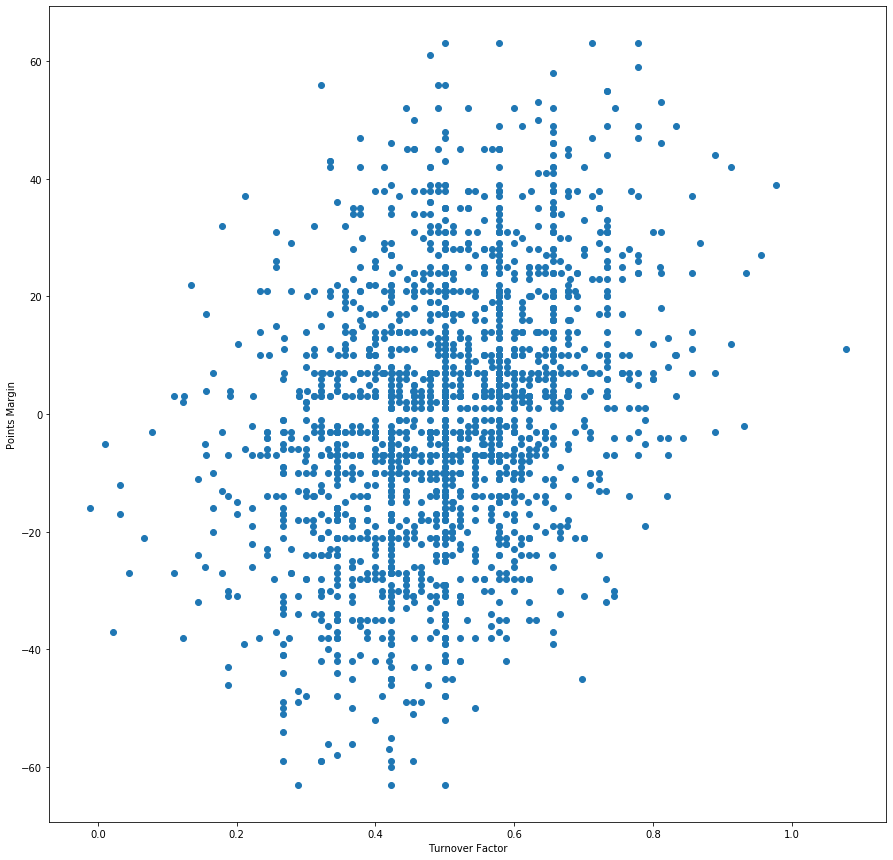

In [186]:
f, ax = plt.subplots(1, figsize=(15, 15))

ax.scatter(matx_factors["Trnovr"], matx_factors.ActPtsDiff);
ax.set_xlabel("Turnover Factor")
ax.set_ylabel("Points Margin");

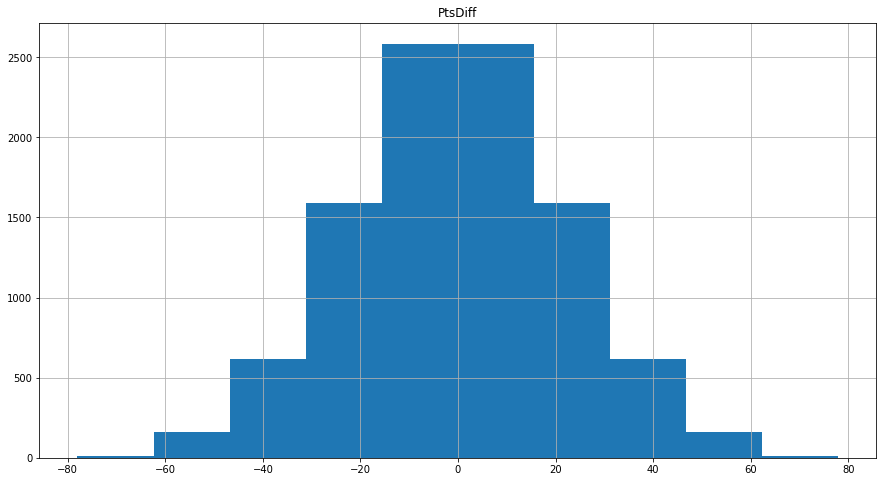

In [187]:
stored_game_boxes.hist(column='PtsDiff', figsize=(15,8));

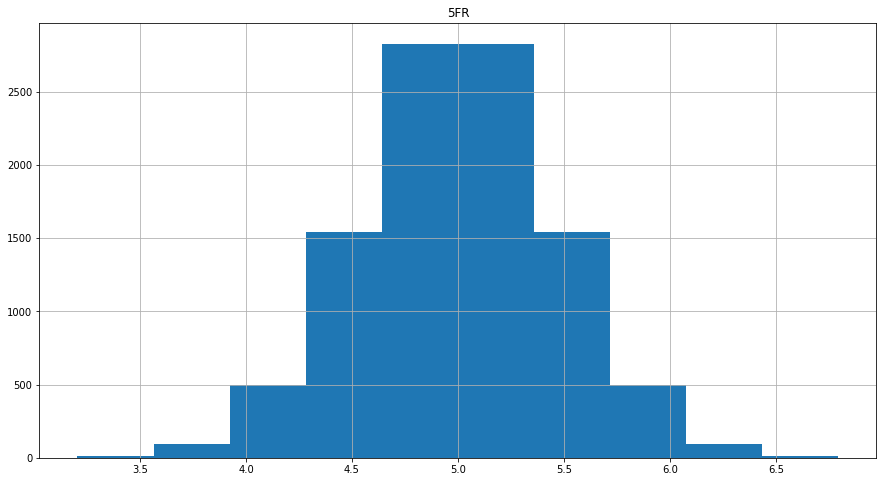

In [188]:
stored_game_boxes.hist(column='5FR', figsize=(15,8));

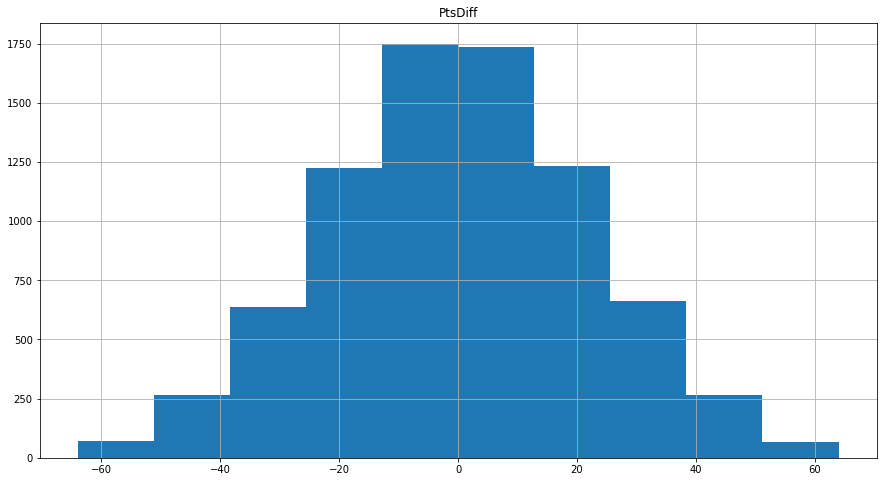

In [189]:
train_data.hist(column='PtsDiff', figsize=(15,8));

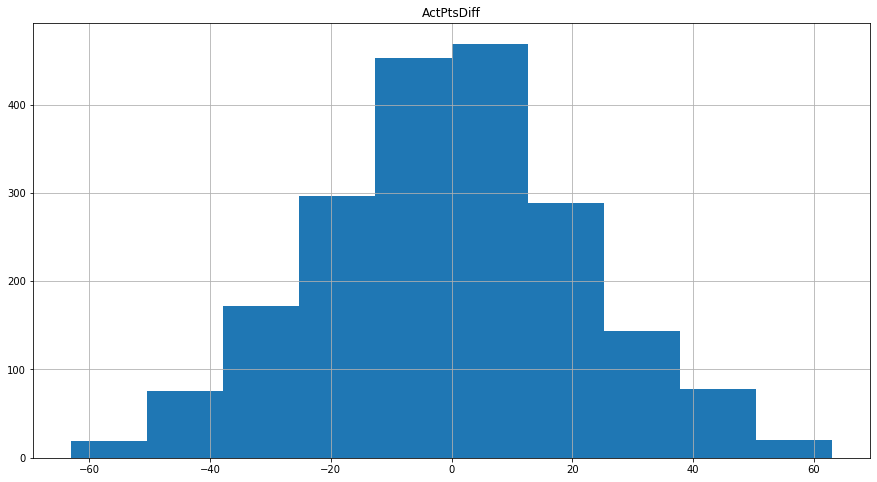

In [190]:
test.hist(column='ActPtsDiff', figsize=(15,8));

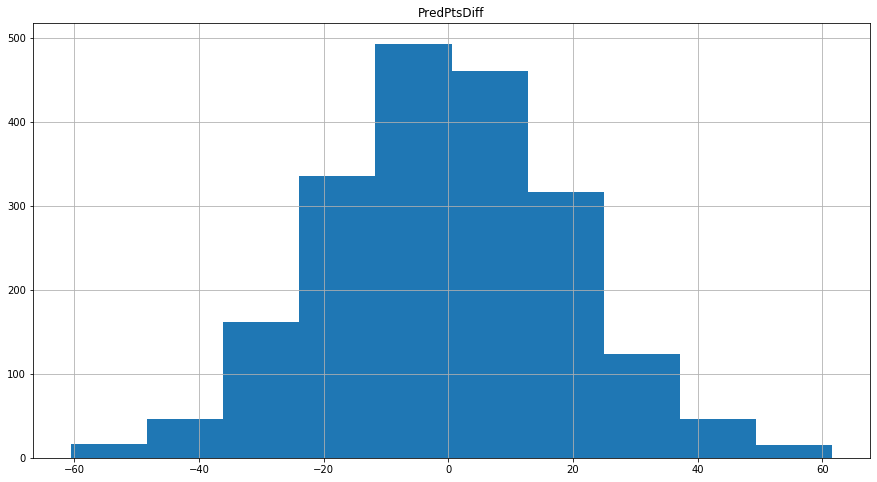

In [191]:
test.hist(column='PredPtsDiff', figsize=(15,8));

In [192]:
def generate_win_prob(game_id, year):
    sample_box = calculate_box_score(game_id, year)
    mu = preds.mean()
    std = preds.std()

    max_box_row = sample_box[sample_box['PtsDiff'] == max(sample_box['PtsDiff'])]
    parts = sample_box.Team.tolist()
    print(f"Game: {parts[0]} @ {parts[1]}")
    print(f"Actual Winner: {stringify_entry(max_box_row.Team)}")
    act_MOV = stringify_entry(max_box_row.PtsDiff)
    print(f"MOV: {stringify_entry(max_box_row.Team)} by {act_MOV}")
#     print(f"5FRDiff for {stringify_entry(max_box_row.Team)}: {stringify_entry(max_box_row['5FRDiff'])}")
    proj_point_diff = model.predict(max_box_row['5FRDiff'][:,np.newaxis])[0]
    print(f"Proj MOV: {stringify_entry(max_box_row.Team)} by {round(proj_point_diff)} (exact value: {proj_point_diff})")
    z = (proj_point_diff - mu) / std
    print(f"Z score: {z}")
    win_prob = stats.norm.cdf(z)
    print(f"Win Prob for {stringify_entry(max_box_row.Team)}: {(100 * win_prob):.2f}%")
    print("---")
    
    return [win_prob, act_MOV]

In [193]:
generate_win_prob(401013183, 2018)  # 2018 UVA at VT for sample (this should be in the dataset, so not ideal)
calculate_box_score(401013183, 2018)

Game: Virginia @ Virginia Tech
Actual Winner: Virginia Tech
MOV: Virginia Tech by 3.0
Proj MOV: Virginia Tech by -4.0 (exact value: -4.411249206379292)
Z score: -0.20277070523651594
Win Prob for Virginia Tech: 41.97%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Virginia,2018,401013183,31.0,-3.0,0.875665,0.396825,0.111111,6.507937,0.930578,...,0.118588,0.994779,-0.66,-1,0.103211,2.077885,0.124959,-0.040309,5.102837,0.205675
1,Virginia Tech,2018,401013183,34.0,3.0,0.124335,0.368421,0.078947,5.513158,0.805619,...,-0.118588,-0.994779,0.66,1,-0.103211,-2.077885,-0.124959,0.040309,4.897163,-0.205675


In [194]:
generate_win_prob(401112488, 2019)  # 2019 GT at MIA
calculate_box_score(401112488, 2019)

Game: Georgia Tech @ Miami
Actual Winner: Georgia Tech
MOV: Georgia Tech by 7.0
Proj MOV: Georgia Tech by -16.0 (exact value: -15.791094486747335)
Z score: -0.7877333884138475
Win Prob for Georgia Tech: 21.54%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Georgia Tech,2019,401112488,28.0,7.0,0.065752,0.396825,0.111111,5.460317,0.894136,...,0.07619,-0.330005,-0.66,1,-0.014422,-0.482035,-0.121075,0.018689,4.630449,-0.739101
1,Miami,2019,401112488,21.0,-7.0,0.934248,0.370968,0.112903,5.790323,1.015211,...,-0.07619,0.330005,0.66,-1,0.014422,0.482035,0.121075,-0.018689,5.369551,0.739101


In [195]:
generate_win_prob(401112513, 2019)  # 2019 NCST at GT
calculate_box_score(401112513, 2019)

Game: NC State @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 2.0
Proj MOV: Georgia Tech by -6.0 (exact value: -6.426584935559428)
Z score: -0.3063658039922197
Win Prob for Georgia Tech: 37.97%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,NC State,2019,401112513,26.0,-2.0,0.156447,0.487500,0.150000,5.712500,0.704891,...,-0.01919,-1.322588,0.0,-2,-0.129463,1.273286,-0.300725,0.012719,5.150071,0.300143
1,Georgia Tech,2019,401112513,28.0,2.0,0.843553,0.473684,0.140351,7.035088,1.005617,...,0.01919,1.322588,0.0,2,0.129463,-1.273286,0.300725,-0.012719,4.849929,-0.300143


In [196]:
generate_win_prob(401110863, 2019)  # 2019 Ole Miss at MSST
calculate_box_score(401110863, 2019)

Game: Ole Miss @ Mississippi State
Actual Winner: Mississippi State
MOV: Mississippi State by 1.0
Proj MOV: Mississippi State by 6.0 (exact value: 5.595736309151614)
Z score: 0.3116223250255205
Win Prob for Mississippi State: 62.23%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Ole Miss,2019,401110863,20.0,-1.0,0.384124,0.422535,0.084507,5.563380,0.880173,...,-0.059649,0.080622,0.22,1,0.020976,6.298842,0.092249,0.000243,4.8683,-0.263399
1,Mississippi State,2019,401110863,21.0,1.0,0.615876,0.413793,0.137931,5.482759,0.787924,...,0.059649,-0.080622,-0.22,-1,-0.020976,-6.298842,-0.092249,-0.000243,5.1317,0.263399


In [197]:
generate_win_prob(401012356, 2018) # 2018 LSU vs TAMU  (this should be in the dataset, so not ideal)
calculate_box_score(401012356, 2018)

Game: LSU @ Texas A&M
Actual Winner: Texas A&M
MOV: Texas A&M by 2.0
Proj MOV: Texas A&M by -8.0 (exact value: -7.994649534430608)
Z score: -0.38696964811771783
Win Prob for Texas A&M: 34.94%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,LSU,2018,401012356,72.0,-2.0,0.321374,0.466667,0.088889,5.511111,0.682602,...,0.014666,0.876496,0.0,-1,-0.103285,-15.374294,-0.349878,0.001282,5.186823,0.373645
1,Texas A&M,2018,401012356,74.0,2.0,0.678626,0.423077,0.105769,4.634615,1.032480,...,-0.014666,-0.876496,0.0,1,0.103285,15.374294,0.349878,-0.001282,4.813177,-0.373645


In [198]:
# Team Ratings by Avg Win Prob??
def calculate_avg_win_prob(team, year):
#     print(team)
    tester = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == year)]
    if (len(tester) == 0):
        return 0
    pred = model.predict([[tester['5FRDiff'].mean()]])
    mu = preds.mean()
    std = preds.std()
    z = (pred[0] - mu) / std
#     print(f"Avg Win Prob for {team}: {(100 * stats.norm.cdf(z)):.2f}%")
    win_prob = stats.norm.cdf(z)
    return win_prob

consider_teams = teams[teams.conference.isin(fbs)].school.tolist()
team_wp_frame = pd.DataFrame({"team":consider_teams})
team_wp_frame['avg_win_prob'] = team_wp_frame.apply(lambda x: calculate_avg_win_prob(x.team, 2019), axis=1)
# for team in team_list:
#     team_wp_frame = team_wp_frame.append(pd.DataFrame({
#         'team':[team],
#         'avg_win_prob':[calculate_avg_win_prob(team, 2019)]
#     }))
team_wp_frame['games'] = team_wp_frame.apply(lambda x: len(games[(games.season == 2019) & ((games.home_team == x.team) | (games.away_team == x.team))]), axis=1)
team_wp_frame['proj_wins'] = round(team_wp_frame.avg_win_prob * team_wp_frame.games)
team_wp_frame['proj_losses'] = team_wp_frame.games - team_wp_frame['proj_wins']
team_wp_frame = team_wp_frame.sort_values(by=['avg_win_prob','games'], ascending=False)
team_wp_frame.index = range(1,len(team_wp_frame.team)+1)
team_wp_frame

,team,avg_win_prob,games,proj_wins,proj_losses
1,Ohio State,0.940420,13,12.0,1.0
2,Clemson,0.935062,13,12.0,1.0
3,Alabama,0.923026,12,11.0,1.0
4,LSU,0.910913,13,12.0,1.0
5,Wisconsin,0.850616,13,11.0,2.0
...,...,...,...,...,...
126,Bowling Green,0.136457,12,2.0,10.0
127,UMass,0.111148,12,1.0,11.0
128,Akron,0.102867,12,1.0,11.0
129,Rutgers,0.098641,12,1.0,11.0


In [199]:
# Team Ratings by Avg Win Prob??
def calculate_z(item, mu, std):
    return (item - mu) / std

def calculate_second_order_wins(team, year):
#     print(team)
    tester = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == year)]
    if (len(tester) == 0):
        return 0
    pred = model.predict(tester['5FRDiff'][:,np.newaxis])
    mu = preds.mean()
    std = preds.std()
    zs = np.vectorize(calculate_z)(pred, mu, std)
    probs = stats.norm.cdf(zs)
    return probs.sum()

team_second_order_frame = pd.DataFrame({"team":consider_teams})
team_second_order_frame["second_order_wins"] = team_second_order_frame.apply(lambda x: calculate_second_order_wins(x.team, 2019),axis=1)
team_second_order_frame["second_order_losses"] = team_second_order_frame.apply(lambda x: len(games[((games.home_team == x.team) | (games.away_team == x.team)) & (games.season == 2019)]) - x.second_order_wins,axis=1)
team_second_order_frame.sort_values(by=['second_order_wins'], ascending=False)

,team,second_order_wins,second_order_losses
77,Ohio State,11.322388,1.677612
21,Clemson,10.562182,2.437818
53,LSU,10.391462,2.608538
2,Alabama,9.353557,2.646443
128,Wisconsin,9.318982,3.681018
...,...,...,...
25,Connecticut,2.130455,9.869545
1,Akron,2.061237,9.938763
112,UMass,2.047767,9.952233
103,Texas State,2.045101,9.954899


In [200]:
# Matchup Predictor?
grouped_by_year = stored_game_boxes.copy().groupby(['Team','Season'])
ratings = grouped_by_year.apply(lambda x: x['5FR'].mean())
team_fr_year = ratings.reset_index()
team_fr_year.columns = ["Team",'Season','5FR']
team_fr_year

tmp = team_fr_year.groupby('Season').apply(lambda x: x.sort_values(by='5FR', ascending=False)).reset_index(drop=True)
team_strength = pd.DataFrame()
for yr in range(2012, 2020):
    retrieve = tmp[tmp.Season == yr].copy()
    retrieve['Rank'] = range(1, len(retrieve)+1)
    team_strength = team_strength.append(retrieve)
team_strength

,Team,Season,5FR,Rank
0,Alabama,2012,5.606624,1.0
1,Florida State,2012,5.456845,2.0
2,Fresno State,2012,5.371180,3.0
3,Arizona State,2012,5.339381,4.0
4,Oklahoma,2012,5.339329,5.0
...,...,...,...,...
897,Connecticut,2019,4.497653,126.0
898,Bowling Green,2019,4.489725,127.0
899,UMass,2019,4.433154,128.0
900,Akron,2019,4.412666,129.0


In [201]:
def filter_opponents(box, team):
    return box[box.Team != team].Team.tolist()[0]

# grouped_by_team = stored_game_boxes.groupby(['GameID'])
opponent_game_ids = pd.DataFrame()
for team in team_list:
    team_games = stored_game_boxes[stored_game_boxes.Team == team].GameID.to_list()
    for idx, item in enumerate(team_games, start=1):
        box = stored_game_boxes[stored_game_boxes.GameID == item]
        opp = filter_opponents(box, team)
        opponent_game_ids = opponent_game_ids.append({'GameID' : item, 'Team':team,'Opponent':opp,'Season':stringify_entry(box.Season), 'Week': idx}, ignore_index=True)
opponent_game_ids

,GameID,Opponent,Season,Team,Week
0,322520130.0,Michigan,2012.0,Air Force,1.0
1,322662439.0,UNLV,2012.0,Air Force,2.0
2,322732005.0,Colorado State,2012.0,Air Force,3.0
3,322802005.0,Navy,2012.0,Air Force,4.0
4,322872751.0,Wyoming,2012.0,Air Force,5.0
...,...,...,...,...,...
9864,401117533.0,Nevada,2019.0,Wyoming,71.0
9865,401117541.0,Boise State,2019.0,Wyoming,72.0
9866,401117546.0,Utah State,2019.0,Wyoming,73.0
9867,401117550.0,Colorado State,2019.0,Wyoming,74.0


In [202]:
def predict_matchup(team1, team2, year, week = -1, games_to_consider = 4):
    # Start with some default values
    natl_avg = team_strength[(team_strength.Season == year)]['5FR'].mean()
    fcs = team_strength[(team_strength.Season == year)].quantile(.02)['5FR'] # assume any/all FCS team is only as good as the bottom 2% of FBS
    if (games_to_consider <= 0):
        games_to_consider = 16 # consider all games
    
    if (week <= 0):
        week = 16 # consider all weeks
        
#     print(grouped_by_year.get_group((team1, year))[:1].tail(4))
    
    # Generate comparison attributes for team 1
    team1_avg_ffr = grouped_by_year.get_group((team1, year))[:week]['5FR'].tail(games_to_consider).mean() if ((team1, year) in grouped_by_year.groups) else natl_avg
    team1_sos = natl_avg
    team1_opps = opponent_game_ids[(opponent_game_ids.Team == team1) & (opponent_game_ids.Week < week)][:week].Opponent.to_list()
    team1_record = teams[(teams.school == team1)]
    team1_conf = stringify_entry(team1_record.conference)
    team1_conf_teams = teams[teams.conference == team1_conf].school.to_list()

    if ~(team1_record.conference.isin(fbs).any()):
        team1_avg_ffr = fcs
        team1_sos = fcs
        team1_conf_sos = fcs
        team1_subdiv_sos = fcs
    else:
        team1_sos = team_strength[(team_strength.Team.isin(team1_opps)) & (team_strength.Season == year)]['5FR'].mean()
        team1_conf_sos = team_strength[(team_strength.Team.isin(team1_conf_teams)) & (team_strength.Season == year)]['5FR'].mean()
        team1_p5 = (stringify_entry(team1_record.conference) in p5)
        team1_subdiv_members = teams[teams.conference.isin(fbs) & (teams.conference.isin(p5) == team1_p5)].school.to_list()
        team1_subdiv_sos = team_strength[(team_strength.Team.isin(team1_subdiv_members)) & (team_strength.Season == year)]['5FR'].mean()

    # Generate comparison attributes for team 2
    team2_avg_ffr = grouped_by_year.get_group((team2, year))[:week]['5FR'].tail(games_to_consider).mean() if ((team2, year) in grouped_by_year.groups) else natl_avg
    team2_sos = natl_avg
    team2_record = teams[(teams.school == team2)]
    team2_conf = stringify_entry(team2_record.conference)
    team2_conf_teams = teams[teams.conference == team2_conf].school.to_list()
    team2_opps = opponent_game_ids[(opponent_game_ids.Team == team2) & (opponent_game_ids.Week < week)][:week].Opponent.to_list()
    if ~(team2_record.conference.isin(fbs).any()):
        team2_avg_ffr = fcs
        team2_sos = fcs
        team2_conf_sos = fcs
        team2_subdiv_sos = fcs
    else:
        team2_sos = team_strength[(team_strength.Team.isin(team2_opps)) & (team_strength.Season == year)]['5FR'].mean()
        team2_conf_sos = team_strength[(team_strength.Team.isin(team2_conf_teams)) & (team_strength.Season == year)]['5FR'].mean()
        team2_p5 = (stringify_entry(team2_record.conference) in p5)
        team2_subdiv_members = teams[teams.conference.isin(fbs) & (teams.conference.isin(p5) == team2_p5)].school.to_list()
        team2_subdiv_sos = team_strength[(team_strength.Team.isin(team2_subdiv_members)) & (team_strength.Season == year)]['5FR'].mean()
    
    # adjust based on fcs vs fbs AND overall strength of schedule
    if (team2_sos < team1_sos):
        team2_avg_ffr *= (team2_sos / team1_sos)
    elif (team2_sos > team1_sos):
        team1_avg_ffr *= (team1_sos / team2_sos)
        
    # adjust based on p5 vs g5
    if (team2_subdiv_sos < team1_subdiv_sos):
        team2_avg_ffr *= (team2_subdiv_sos / team1_subdiv_sos)
    elif (team2_subdiv_sos > team1_subdiv_sos):
        team1_avg_ffr *= (team1_subdiv_sos / team2_subdiv_sos)
        
    # adjust based on conference SoS
    if (team2_conf_sos < team1_conf_sos):
        team2_avg_ffr *= (team2_conf_sos / team1_conf_sos)
    elif (team2_conf_sos > team1_conf_sos):
        team1_avg_ffr *= (team1_conf_sos / team2_conf_sos)
    
    ffr_diff = team1_avg_ffr - team2_avg_ffr # assumes team_1 is home
    pred = model.predict([[ffr_diff]])
    mu = preds.mean()
    std = preds.std()
    z = (pred[0] - mu) / std
    win_prob = stats.norm.cdf(z)
    return [win_prob, pred[0]]

predict_matchup('Georgia Tech', 'Clemson', 2019, 0, -1)

[0.14947682810823348, -20.672998873236505]

In [203]:
team_triples = [
#     ['Buffalo', 'Charlotte', 7], # Buff 31, Char 9
#     ['Utah State', 'Kent State', 7], # Kent 51, Utah 41
#     ['San Diego State', 'Central Michigan', 3.5], # SDSU 48, CMU 11
#     ['Georgia Southern','Liberty', 4.5], # Lib 23, GASO 16
#     ['SMU','Florida Atlantic', 7], # FAU 52, SMU 28
#     ['Florida International','Arkansas State', 1], # ArkSt 34, FIU 28
#     ['Washington', 'Boise State', 3.5], # Wash 38, Boise 7
#     ['Appalachian State', 'UAB', 17], # App 31, UAB 17
#     ['UCF','Marshall',15], # UCF 48, Marshall 25
#     ['BYU',"Hawai'i",2], # Hawaii 38, BYU 34
#    ----- 7-3 ML / 5-5 ATS ------
#     ['Miami','Louisiana Tech',6], # LaTech 14, Miami 0
#     ['Pittsburgh','Eastern Michigan',11], # Pitt 34, EMU 30
#    ----- 8-4 ML / 6-6 ATS ------ 
    ['North Carolina','Temple',5],
    ['Michigan State','Wake Forest',3.5],
    ['Texas A&M', 'Oklahoma State', 7],
    ['Iowa', 'USC', 2.5],
    ['Air Force', 'Washington State', 3],
    ['Penn State','Memphis',7], # Cotton Bowl
    ['Notre Dame', 'Iowa State', 4],
    ['LSU','Oklahoma',11], # CFP Semifinal: Peach Bowl
    ['Clemson','Ohio State',2.5], # CFP Semifinal: Fiesta Bowl
    ['Western Kentucky', 'Western Michigan', 3.5],
    ['Mississippi State', 'Louisville', 4],
    ['California', 'Illinois', 6.5],
    ['Florida','Virginia',14], # Orange Bowl
    ['Virginia Tech', 'Kentucky', 3],
    ['Arizona State', 'Florida State', 4],
    ['Navy', 'Kansas State', 2],
    ['Wyoming', 'Georgia State', 7],
    ['Utah', 'Texas', 7],
    ['Auburn', 'Minnesota', 7.5],
    ['Alabama', 'Michigan', 7],
    ['Wisconsin','Oregon',2.5], # Rose Bowl
    ['Georgia','Baylor',7.5], # Sugar Bowl
    ['Cincinnati', 'Boston College',7],
    ['Tennessee', 'Indiana', 1.5],
    ['Ohio', 'Nevada', 7.5],
    ['Tulane', 'Southern Mississippi', 7],
    ['Louisiana', 'Miami (OH)', 14]
]

bets = pd.DataFrame()

for data in team_triples:
    team1 = data[0]
    team2 = data[1]
    spread = data[2] # team 1 is always favorite
    predictor = predict_matchup(team1, team2, 2019)
    bets = bets.append(pd.DataFrame({
        "favorite": [team1],
        "opponent" : [team2],
        "spread" : [spread],
        "proj_MOV" : [predictor[1]],
        "proj_win_prob" : [predictor[0]],
        "proj_cover_status" : [predictor[1] > spread],
        "ml_pick": [team1 if (predictor[1] > 0) else team2],
        "ats_pick": [team1 if (predictor[1] > spread) else team2]
    }))
    
bets #.sort_values(by=['proj_cover_status','proj_MOV'], ascending=False)

,favorite,opponent,spread,proj_MOV,proj_win_prob,proj_cover_status,ml_pick,ats_pick
0,Miami,Louisiana Tech,6.0,9.358322,0.693232,True,Miami,Miami
0,Pittsburgh,Eastern Michigan,11.0,2.847214,0.567628,False,Pittsburgh,Eastern Michigan
0,North Carolina,Temple,5.0,-2.130990,0.465909,False,Temple,Temple
0,Michigan State,Wake Forest,3.5,13.963030,0.770874,True,Michigan State,Michigan State
0,Texas A&M,Oklahoma State,7.0,1.229048,0.534728,False,Texas A&M,Oklahoma State
0,Iowa,USC,2.5,3.275496,0.576268,True,Iowa,Iowa
0,Air Force,Washington State,3.0,2.094369,0.552366,False,Air Force,Washington State
0,Penn State,Memphis,7.0,-0.233739,0.504774,False,Memphis,Memphis
0,Notre Dame,Iowa State,4.0,8.017201,0.668616,True,Notre Dame,Notre Dame
0,LSU,Oklahoma,11.0,10.023627,0.705136,False,LSU,Oklahoma


In [204]:
generate_win_prob(401112521, 2019)  # 2019 VT @ UVA
calculate_box_score(401112521, 2019)

Game: Virginia Tech @ Virginia
Actual Winner: Virginia
MOV: Virginia by 9.0
Proj MOV: Virginia by 6.0 (exact value: 6.176313046707429)
Z score: 0.3414659404547109
Win Prob for Virginia: 63.36%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Virginia Tech,2019,401112521,30.0,-9.0,0.577256,0.432432,0.162162,6.540541,1.169095,...,0.073684,-2.332187,0.66,3,-0.135068,2.373916,-0.403644,-0.089435,4.854693,-0.290614
1,Virginia,2019,401112521,39.0,9.0,0.422744,0.381818,0.181818,8.872727,1.572739,...,-0.073684,2.332187,-0.66,-3,0.135068,-2.373916,0.403644,0.089435,5.145307,0.290614


In [205]:
generate_win_prob(401112475, 2019) # 2019 UNC at GT
calculate_box_score(401112475, 2019)

Game: North Carolina @ Georgia Tech
Actual Winner: North Carolina
MOV: North Carolina by 16.0
Proj MOV: North Carolina by 12.0 (exact value: 11.926864409831841)
Z score: 0.637063804243376
Win Prob for North Carolina: 73.80%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,North Carolina,2019,401112475,38.0,16.0,0.98905,0.457447,0.106383,5.744681,0.811309,...,-0.123887,-0.349659,0.0,-1,-0.01403,15.633715,-0.235394,0.079888,5.280084,0.560169
1,Georgia Tech,2019,401112475,22.0,-16.0,0.01095,0.396226,0.150943,6.094340,1.046703,...,0.123887,0.349659,0.0,1,0.01403,-15.633715,0.235394,-0.079888,4.719916,-0.560169


In [206]:
generate_win_prob(401112498, 2019) # 2019 Pitt at GT
calculate_box_score(401112498, 2019)

Game: Pittsburgh @ Georgia Tech
Actual Winner: Pittsburgh
MOV: Pittsburgh by 10.0
Proj MOV: Pittsburgh by 14.0 (exact value: 14.381929523307328)
Z score: 0.7632624862791685
Win Prob for Pittsburgh: 77.73%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Pittsburgh,2019,401112498,20.0,10.0,0.970074,0.362319,0.057971,5.086957,0.882151,...,0.20743,1.49512,0.0,1,0.130501,14.249196,-0.248736,0.038746,5.337625,0.675249
1,Georgia Tech,2019,401112498,10.0,-10.0,0.029926,0.204082,0.061224,3.591837,1.130888,...,-0.20743,-1.49512,0.0,-1,-0.130501,-14.249196,0.248736,-0.038746,4.662375,-0.675249


In [207]:
generate_win_prob(401110865, 2019) # 2019 Iron Bowl
calculate_box_score(401110865, 2019)

Game: Alabama @ Auburn
Actual Winner: Auburn
MOV: Auburn by 3.0
Proj MOV: Auburn by -8.0 (exact value: -7.83432535867608)
Z score: -0.3787284411665694
Win Prob for Auburn: 35.24%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Alabama,2019,401110865,45.0,-3.0,0.400109,0.453333,0.133333,6.440000,0.905516,...,0.114729,1.117419,0.44,1,0.063274,9.532495,-0.083465,-0.033763,5.183065,0.36613
1,Auburn,2019,401110865,48.0,3.0,0.599891,0.338710,0.112903,5.322581,0.988981,...,-0.114729,-1.117419,-0.44,-1,-0.063274,-9.532495,0.083465,0.033763,4.816935,-0.36613


In [208]:
generate_win_prob(401110867, 2019)
calculate_box_score(401110867, 2019)

Game: Georgia @ Georgia Tech
Actual Winner: Georgia
MOV: Georgia by 45.0
Proj MOV: Georgia by 26.0 (exact value: 25.911499603389853)
Z score: 1.3559215324931986
Win Prob for Georgia: 91.24%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Georgia,2019,401110867,52.0,45.0,0.998507,0.472222,0.138889,6.847222,0.969971,...,-0.047059,4.45067,0.0,2,0.330151,25.998278,0.455922,0.020115,5.607847,1.215694
1,Georgia Tech,2019,401110867,7.0,-45.0,0.001493,0.224138,0.034483,2.396552,0.514049,...,0.047059,-4.45067,0.0,-2,-0.330151,-25.998278,-0.455922,-0.020115,4.392153,-1.215694


In [209]:
def filter_opponent(box, team):
    return box[box.Team != team].Team.tolist()[0]

def filter_MOV(box, team):
    return box[box.Team == team].PtsDiff.tolist()[0]

def clean_win_prob(row, year):
    prob = generate_win_prob(row.GameID, year)[0]
    return prob if row.ActualMOV > 0 else 1-prob

def clean_prediction_prob(row, team, year, idx):
    parts = row.Team.tolist()
    prob = predict_matchup(parts[1],parts[0], year, idx)[0] if idx > 0 else predict_matchup(parts[1],parts[0], year-1, -1)[0]
    return prob if team == parts[1] else 1-prob

def clean_prediction_mov(row, team, year, idx):
    parts = row.Team.tolist()
    mov = predict_matchup(parts[1],parts[0], year, idx)[1] if idx > 0 else predict_matchup(parts[1],parts[0], year-1, -1)[1]
    return mov if team == parts[1] else -1*mov

def generate_schedule_analysis(team, year):
    game_ids = games[((games.home_team == team) | (games.away_team == team)) & (games.season == year)].id
    frame = pd.DataFrame(data={"GameID":game_ids,"Year":year})
    frame.reset_index(inplace=True, drop=True)
    frame['Team'] = team
    frame['Opponent'] = frame.apply(lambda y: filter_opponent(calculate_box_score(y.GameID, year),team), axis=1)
    frame['PredWinProb'] = frame.apply(lambda y: clean_prediction_prob(calculate_box_score(y.GameID, year),team, year, y.name) * 100, axis=1)
    frame['PredMOV'] = frame.apply(lambda y: clean_prediction_mov(calculate_box_score(y.GameID, year),team, year, y.name), axis=1)
    frame['ActualMOV'] = frame.apply(lambda y: filter_MOV(calculate_box_score(y.GameID, year),team), axis=1)
    frame['PostGameWinProb'] = frame.apply(lambda x: clean_win_prob(x, year) * 100, axis=1)
    return frame

gatech_results = generate_schedule_analysis("Georgia Tech", 2019)
gatech_results

Game: Georgia Tech @ Clemson
Actual Winner: Clemson
MOV: Clemson by 38.0
Proj MOV: Clemson by 19.0 (exact value: 19.474857537629614)
Z score: 1.0250562772392695
Win Prob for Clemson: 84.73%
---
Game: South Florida @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 4.0
Proj MOV: Georgia Tech by 4.0 (exact value: 4.431552120067657)
Z score: 0.2517793051793708
Win Prob for Georgia Tech: 59.94%
---
Game: The Citadel @ Georgia Tech
Actual Winner: The Citadel
MOV: The Citadel by 3.0
Proj MOV: The Citadel by -13.0 (exact value: -12.982454866141238)
Z score: -0.6433597762890639
Win Prob for The Citadel: 26.00%
---
Game: Georgia Tech @ Temple
Actual Winner: Temple
MOV: Temple by 22.0
Proj MOV: Temple by 26.0 (exact value: 25.646608415561566)
Z score: 1.3423052261055028
Win Prob for Temple: 91.03%
---
Game: North Carolina @ Georgia Tech
Actual Winner: North Carolina
MOV: North Carolina by 16.0
Proj MOV: North Carolina by 12.0 (exact value: 11.926864409831841)
Z score: 0.637063804243

,GameID,Year,Team,Opponent,PredWinProb,PredMOV,ActualMOV,PostGameWinProb
0,401111653,2019,Georgia Tech,Clemson,19.750409,-16.080410,-38.0,15.266832
1,401112441,2019,Georgia Tech,South Florida,80.824130,16.486288,4.0,59.939417
2,401112452,2019,Georgia Tech,The Citadel,97.326094,37.099832,-3.0,74.000466
3,401112469,2019,Georgia Tech,Temple,45.012700,-1.971816,-22.0,8.974852
4,401112475,2019,Georgia Tech,North Carolina,52.007036,0.512567,-16.0,26.204164
5,401112480,2019,Georgia Tech,Duke,23.934560,-13.314815,-18.0,26.643373
6,401112488,2019,Georgia Tech,Miami,36.722829,-6.132296,7.0,21.542634
7,401112498,2019,Georgia Tech,Pittsburgh,38.684018,-6.060819,-10.0,22.265343
8,401112504,2019,Georgia Tech,Virginia,33.927538,-7.595978,-5.0,19.095125
9,401112511,2019,Georgia Tech,Virginia Tech,14.500978,-21.050384,-45.0,0.129057


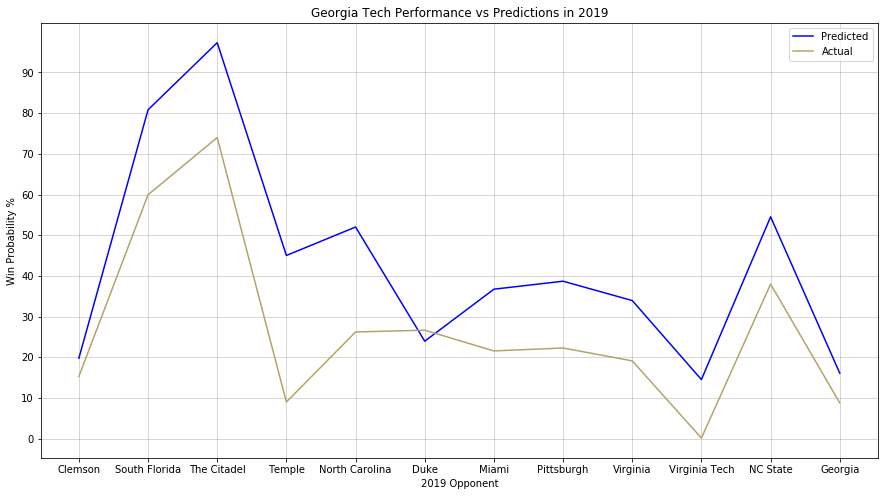

In [210]:
plt.figure(figsize=(15, 8))
plt.plot(gatech_results.Opponent, gatech_results.PredWinProb, color='b', label="Predicted")
plt.plot(gatech_results.Opponent, gatech_results.PostGameWinProb, color='#B3a369', label="Actual")
plt.yticks(np.arange(0, 100, step=10))
plt.grid(linestyle='-', linewidth=0.5)
plt.title("Georgia Tech Performance vs Predictions in 2019")
plt.xlabel('2019 Opponent');
plt.ylabel('Win Probability %')
plt.legend();

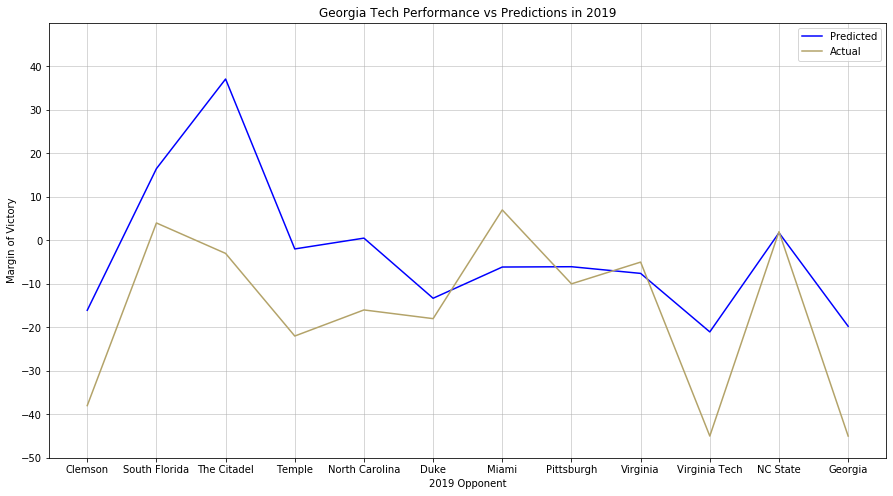

In [211]:
plt.figure(figsize=(15, 8))
plt.plot(gatech_results.Opponent, gatech_results.PredMOV, color='b', label="Predicted")
plt.plot(gatech_results.Opponent, gatech_results.ActualMOV, color='#B3a369', label="Actual")
plt.ylim((-50,50))
plt.yticks(np.arange(-50, 50, step=10))
plt.grid(linestyle='-', linewidth=0.5)
plt.title("Georgia Tech Performance vs Predictions in 2019")
plt.xlabel('2019 Opponent');
plt.ylabel('Margin of Victory');
plt.legend();

Game: Alcorn State @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 41.0
Proj MOV: Georgia Tech by 35.0 (exact value: 34.678593029347724)
Z score: 1.8065798997876967
Win Prob for Georgia Tech: 96.46%
---
Game: Georgia Tech @ South Florida
Actual Winner: South Florida
MOV: South Florida by 11.0
Proj MOV: South Florida by 13.0 (exact value: 12.763073448877762)
Z score: 0.680047787867591
Win Prob for South Florida: 75.18%
---
Game: Georgia Tech @ Pittsburgh
Actual Winner: Pittsburgh
MOV: Pittsburgh by 5.0
Proj MOV: Pittsburgh by 10.0 (exact value: 10.477025519313056)
Z score: 0.5625371629158513
Win Prob for Pittsburgh: 71.31%
---
Game: Clemson @ Georgia Tech
Actual Winner: Clemson
MOV: Clemson by 28.0
Proj MOV: Clemson by 29.0 (exact value: 29.107933675241437)
Z score: 1.5202290960147717
Win Prob for Clemson: 93.58%
---
Game: Bowling Green @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 46.0
Proj MOV: Georgia Tech by 38.0 (exact value: 37.90436748622431)
Z s

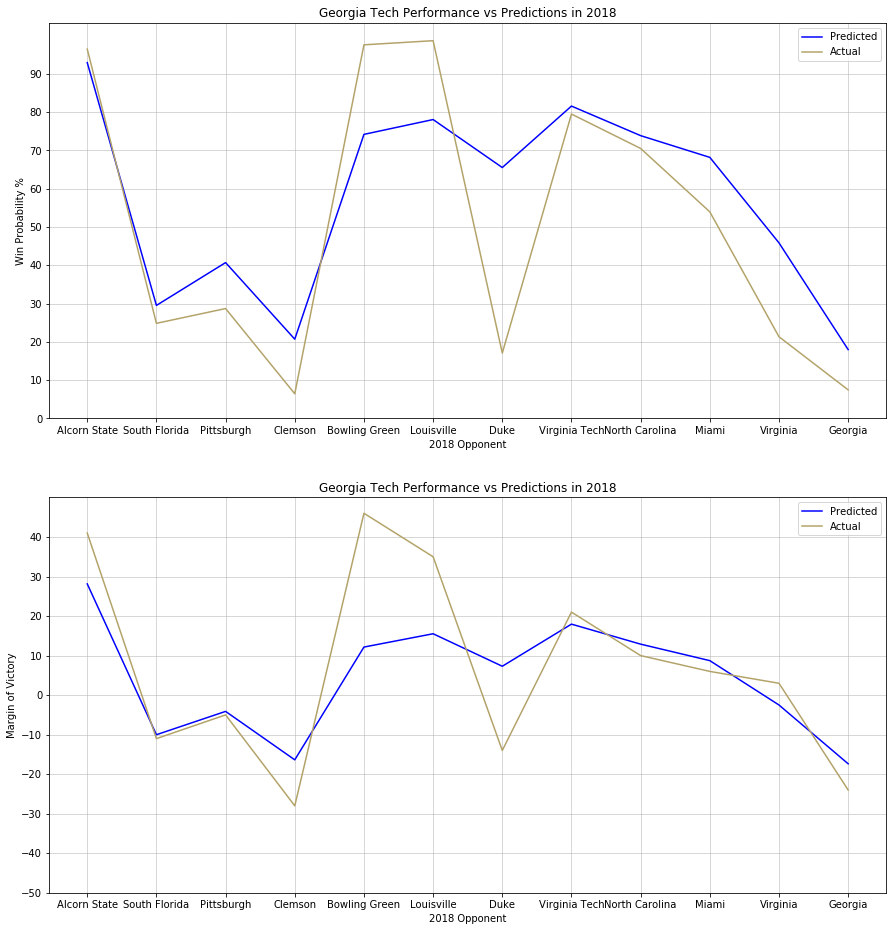

In [219]:
gatech_18_results = generate_schedule_analysis("Georgia Tech", 2018)
fig, axes = plt.subplots(2, figsize=(15,16))

axes[0].plot(gatech_18_results.Opponent, gatech_18_results.PredWinProb, color='b', label="Predicted")
axes[0].plot(gatech_18_results.Opponent, gatech_18_results.PostGameWinProb, color='#B3a369', label="Actual")
axes[0].set_yticks(np.arange(0, 100, step=10))
axes[0].grid(linestyle='-', linewidth=0.5)
axes[0].set_title("Georgia Tech Performance vs Predictions in 2018")
axes[0].set_xlabel('2018 Opponent');
axes[0].set_ylabel('Win Probability %')
axes[0].legend();

axes[1].plot(gatech_18_results.Opponent, gatech_18_results.PredMOV, color='b', label="Predicted")
axes[1].plot(gatech_18_results.Opponent, gatech_18_results.ActualMOV, color='#B3a369', label="Actual")
axes[1].set_ylim(-50,50)
axes[1].set_yticks(np.arange(-50, 50, step=10))
axes[1].grid(linestyle='-', linewidth=0.5)
axes[1].set_title("Georgia Tech Performance vs Predictions in 2018")
axes[1].set_xlabel('2018 Opponent');
axes[1].set_ylabel('Margin of Victory')
axes[1].legend();

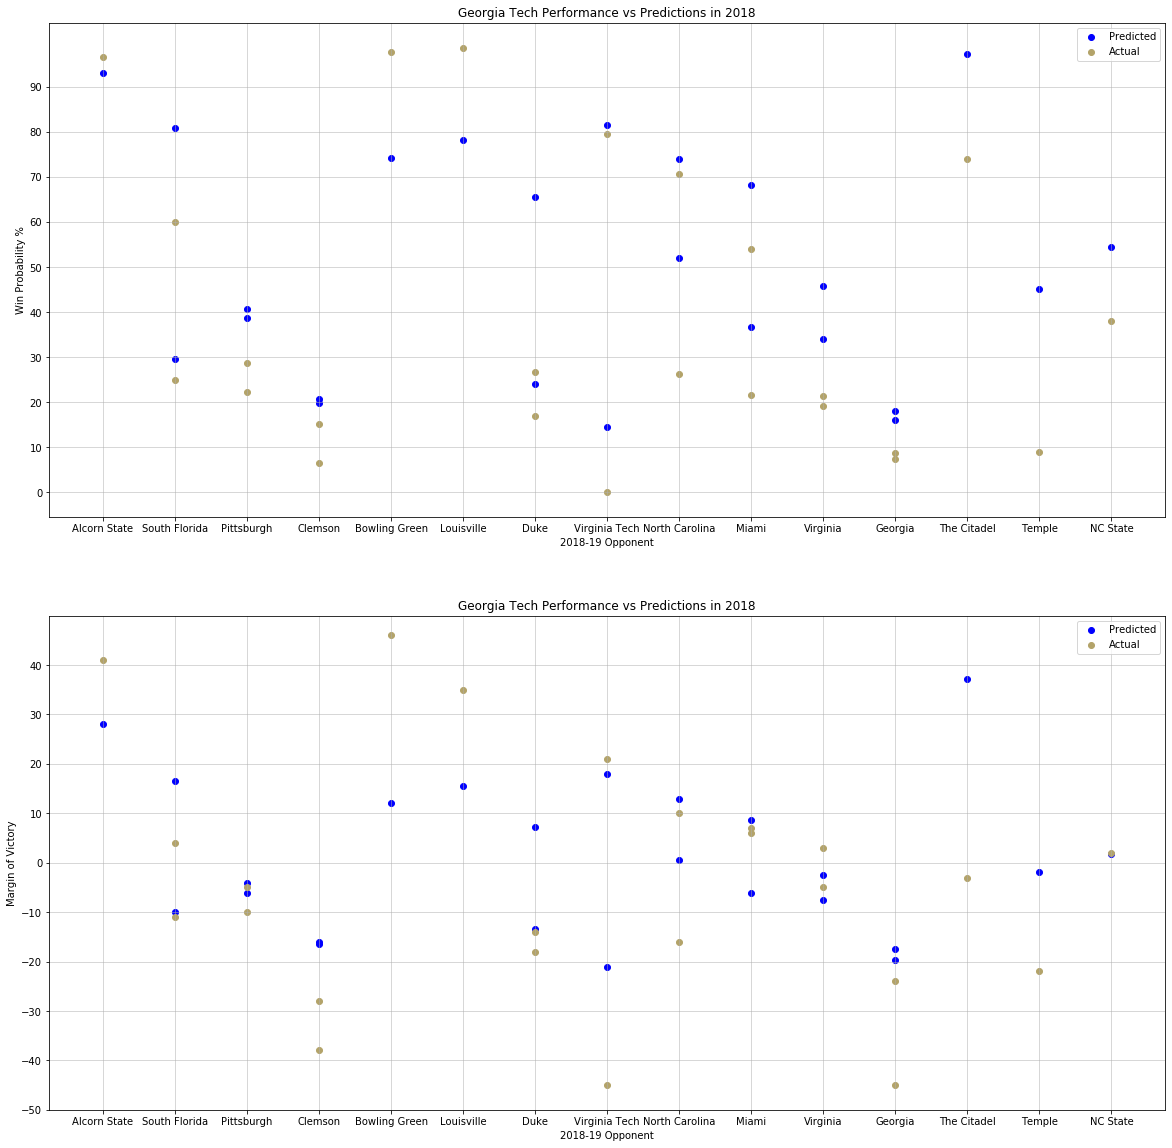

In [220]:
gatech_1819_results = gatech_18_results.append(gatech_results)
fig, axes = plt.subplots(2, figsize=(20,20))
axes[0].scatter(gatech_1819_results.Opponent, gatech_1819_results.PredWinProb, color='b', label="Predicted")
axes[0].scatter(gatech_1819_results.Opponent, gatech_1819_results.PostGameWinProb, color='#B3a369', label="Actual")
axes[0].set_yticks(np.arange(0, 100, step=10))
axes[0].grid(linestyle='-', linewidth=0.5)
axes[0].set_title("Georgia Tech Performance vs Predictions in 2018")
axes[0].set_xlabel('2018-19 Opponent');
axes[0].set_ylabel('Win Probability %')
axes[0].legend();

axes[1].scatter(gatech_1819_results.Opponent, gatech_1819_results.PredMOV, color='b', label="Predicted")
axes[1].scatter(gatech_1819_results.Opponent, gatech_1819_results.ActualMOV, color='#B3a369', label="Actual")
axes[1].set_ylim(-50,50)
axes[1].set_yticks(np.arange(-50, 50, step=10))
axes[1].grid(linestyle='-', linewidth=0.5)
axes[1].set_title("Georgia Tech Performance vs Predictions in 2018")
axes[1].set_xlabel('2018-19 Opponent');
axes[1].set_ylabel('Margin of Victory')
axes[1].legend();

In [221]:
# Stability of 5FR measure YoY
grouped_by_season = stored_game_boxes.copy().groupby(['Season', 'Team'])
tings = grouped_by_season.apply(lambda x: x['5FR'].mean())
team_fr_szn = ratings.reset_index()
team_fr_szn.columns = ["Team",'Season','5FRMean']
team_fr_szn

pivot = team_fr_szn.pivot_table(values='5FRMean', index='Team', columns='Season').reset_index()
pivot.corr()

Season,2012,2013,2015,2016,2017,2018,2019
Season,,,,,,,
2012,1.000000,0.581310,0.435028,0.365191,0.286904,0.285329,0.383764
2013,0.581310,1.000000,0.369550,0.250899,0.232639,0.179753,0.281026
2015,0.435028,0.369550,1.000000,0.642715,0.446838,0.345127,0.368099
2016,0.365191,0.250899,0.642715,1.000000,0.567064,0.409997,0.581482
2017,0.286904,0.232639,0.446838,0.567064,1.000000,0.602075,0.539130
2018,0.285329,0.179753,0.345127,0.409997,0.602075,1.000000,0.583893
2019,0.383764,0.281026,0.368099,0.581482,0.539130,0.583893,1.000000


In [222]:
def clean_prediction_prob_names(row):
    prob = predict_matchup(row.Team, row.Opponent, row.Year - 1, -1, -1)[0]
    return prob

def clean_prediction_mov_names(row):
    mov = predict_matchup(row.Team, row.Opponent, row.Year - 1, -1, -1)[1]
    return mov

def generate_schedule_predictions(team, opponents = pd.DataFrame(), year = 2019):
    frame = pd.DataFrame(data={"Year":year,"Team":team,"Opponent":opponents.Team, "Site":opponents.Site})
    frame.reset_index(inplace=True, drop=True)
    frame['PredWinProb'] = frame.apply(lambda y: clean_prediction_prob_names(y) * 100, axis=1)
    frame['PredMOV'] = frame.apply(lambda y: clean_prediction_mov_names(y), axis=1)
    return frame


opp_2020_df = pd.DataFrame(data={
    "Team" : ["Gardner-Webb","UCF","Duke","Miami","Virginia","North Carolina","Pittsburgh","Syracuse","Virginia Tech","Clemson","Notre Dame","Georgia"],
    "Site" : ["Home","Home","Home","Home","Home","Away","Away","Away","Away","Home","Neutral","Away"]
})
georgia_tech_2020 = generate_schedule_predictions("Georgia Tech", opp_2020_df, 2020)
georgia_tech_2020

,Year,Team,Opponent,Site,PredWinProb,PredMOV
0,2020,Georgia Tech,Gardner-Webb,Home,94.714156,31.005067
1,2020,Georgia Tech,UCF,Home,29.128800,-11.158959
2,2020,Georgia Tech,Duke,Home,39.221533,-5.788182
3,2020,Georgia Tech,Miami,Home,27.244015,-12.244951
4,2020,Georgia Tech,Virginia,Home,28.071159,-11.764036
5,2020,Georgia Tech,North Carolina,Away,37.924949,-6.447725
6,2020,Georgia Tech,Pittsburgh,Away,39.578784,-5.607558
7,2020,Georgia Tech,Syracuse,Away,39.408580,-5.693556
8,2020,Georgia Tech,Virginia Tech,Away,29.660060,-10.858919
9,2020,Georgia Tech,Clemson,Home,14.947683,-20.672999


In [223]:
# Model Export snippet

# import pickle
# from datetime import datetime
# now = datetime.now()
# filename = now.strftime("%d-%b-%Y-%H:%M:%S")
# pkl_filename = f"results/wp_model-{filename}.pkl"
# with open(pkl_filename, 'wb') as file:
#     pickle.dump(model, file)